In [1]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
import re
import optuna

/home/thomasdev/anaconda3/envs/ultralytics-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  
torch.cuda.empty_cache()

In [3]:
from modules import (
    get_data_from_trajectory_id,
    create_simple_dataloader,
    Step_1,
    Step_2,
    CombinedHamiltonianLayer,
    SimpleStackedHamiltonianNetwork,
    ReverseStep2,
    ReverseStep1,
    ReverseCombinedHamiltonianLayer,
    InverseStackedHamiltonianNetwork,
    prediction_loss,
    prediction_loss_euclidean,
    load_checkpoint,
    count_parameters,
    hsic_loss_statistics_only,
    hsic_loss
    )

In [4]:
from modules import (    
    calculate_phi_A,
    add_phi_A_columns,
    plot_differencies,
    plot_prediction_vs_ground_truth,
    plot_distance_over_time,
    ensemble_autoregressive_prediction_mahalanobis,
    ensemble_autoregressive_prediction_gaussian_mixture,
    ensemble_autoregressive_prediction_gaussian_mixture_simple,
    test_model_in_single_trajectory,
    analyze_means_with_constants,
    visualize_trajectory_movements_with_std_ellipses,
    visualize_epoch_metrics,
    analyze_folders_means,
    analyze_mapping_net,
    test_model_in_all_trajectories_in_df,
    test_model_variance_in_all_trajectories_in_df,
    plot_prediction_losses,
    plot_variance_losses,
    test_model_with_varying_observed_points,
    test_model_variance_with_varying_observed_points,
    test_model_variance_with_varying_observed_points_multiple_periods,
    compute_jacobian_functional,
    compute_symplectic_product,
    check_canonical_transformation,
    test_canonical_tranformation_on_trajectory,
    test_model_in_all_trajectories_with_different_single_observation_in_df,
    plot_all_transformed_trajectories, 
    plot_all_transformed_trajectories_multiple_periods,
    plot_transformed_trajectory,
    test_model_energy_in_single_trajectory,
    evaluate_all_checkpoints
    )

In [5]:
save_dir_path = "./save_directory_noisy_full_pred_low_samples_pendulum_4" 


In [6]:
with open("all_dataframes_low_samples_pendulum.pkl", "rb") as f:
    loaded_dfs_low_samples_pendulum = pickle.load(f)

# Access them like before:
train_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['train_df_low_samples_pendulum']
val_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['val_df_low_samples_pendulum']
test_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['test_df_low_samples_pendulum']

train_id_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['train_id_df_low_samples_pendulum']
val_id_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['val_id_df_low_samples_pendulum']
test_id_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['test_id_df_low_samples_pendulum']

with open("df_high_energy_low_samples_pendulum.pkl", "rb") as f:
    df_high_energy_low_samples_pendulum = pickle.load(f)

val_df_high_energy_low_samples_pendulum = df_high_energy_low_samples_pendulum['val_df_high_energy_low_samples_pendulum']
val_id_df_high_energy_low_samples_pendulum = df_high_energy_low_samples_pendulum['val_id_df_high_energy_low_samples_pendulum']

test_df_high_energy_low_samples_pendulum = df_high_energy_low_samples_pendulum['test_df_high_energy_low_samples_pendulum']
test_id_df_high_energy_low_samples_pendulum = df_high_energy_low_samples_pendulum['test_id_df_high_energy_low_samples_pendulum']

with open("all_dataframes_low_samples_multiple_periods_pendulum.pkl", "rb") as f:
    df_low_samples_multiple_periods_pendulum = pickle.load(f)

test_df_low_samples_multiple_periods_pendulum = df_low_samples_multiple_periods_pendulum['data_df_low_samples_multiple_periods_pendulum']
test_id_df_low_samples_multiple_periods_pendulum = df_low_samples_multiple_periods_pendulum['id_df_low_samples_multiple_periods_pendulum']




📊 Metric summaries:
  Lowest loss of metric 'val_prediction_loss_' recorded in epoch 1157 with the value: 0.1069, the losses of the last 5 epochs are: ['0.1077', '0.1100', '0.1083', '0.1084', '0.1069']
  Lowest loss of metric 'val_variance_loss_training_set' recorded in epoch 1136 with the value: 0.0032, the losses of the last 5 epochs are: ['0.0032', '0.0033', '0.0033', '0.0033', '0.0033']
  Lowest loss of metric 'val_prediction_loss_training_set' recorded in epoch 1134 with the value: 0.0948, the losses of the last 5 epochs are: ['0.0957', '0.0970', '0.0983', '0.1003', '0.0968']
  Lowest loss of metric 'val_variance_loss_' recorded in epoch 877 with the value: 0.0043, the losses of the last 5 epochs are: ['0.0045', '0.0045', '0.0044', '0.0044', '0.0045']
  Lowest loss of metric 'train_total_loss_' recorded in epoch 1139 with the value: 0.4094, the losses of the last 5 epochs are: ['0.4376', '0.4437', '0.4547', '0.4308', '0.4332']
  Lowest loss of metric 'train_hsic_loss_' recorded i

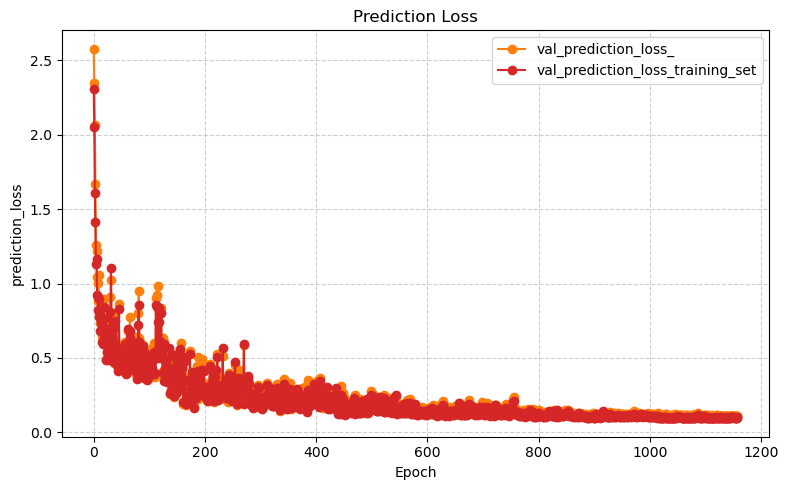

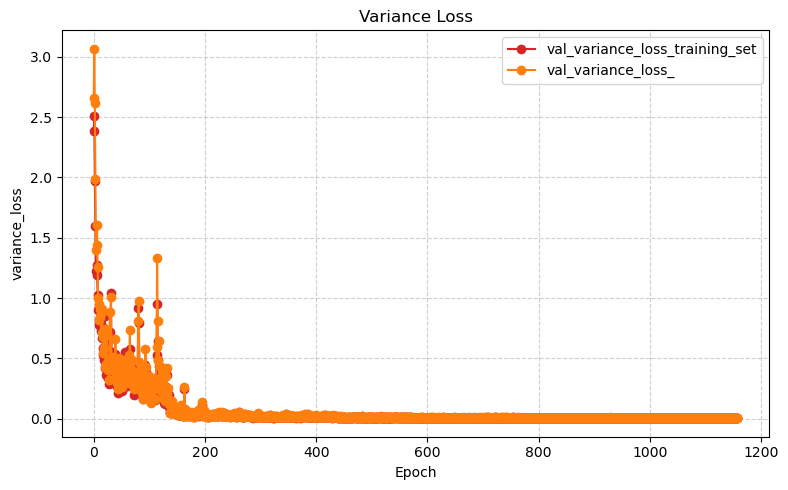

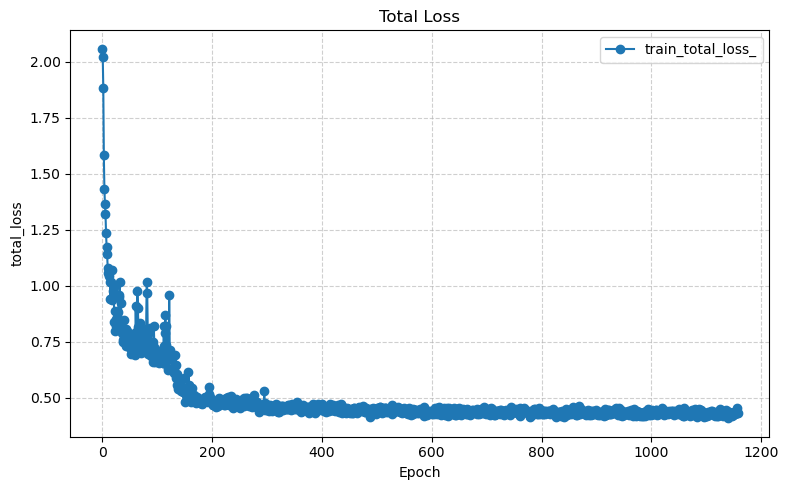

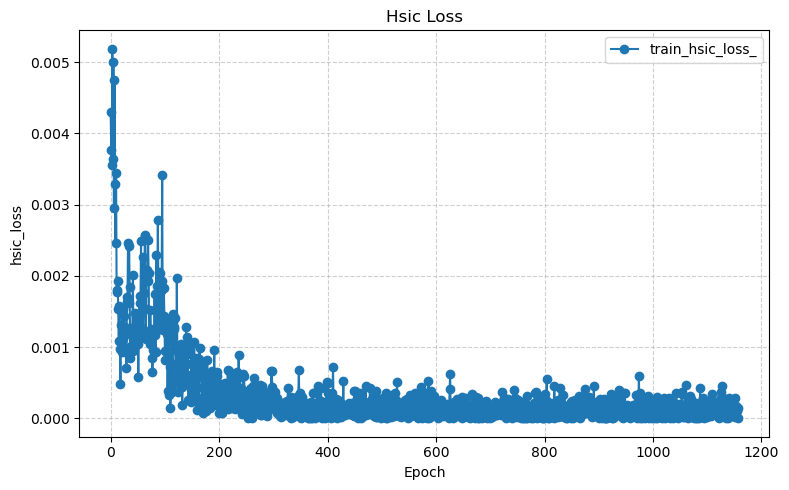

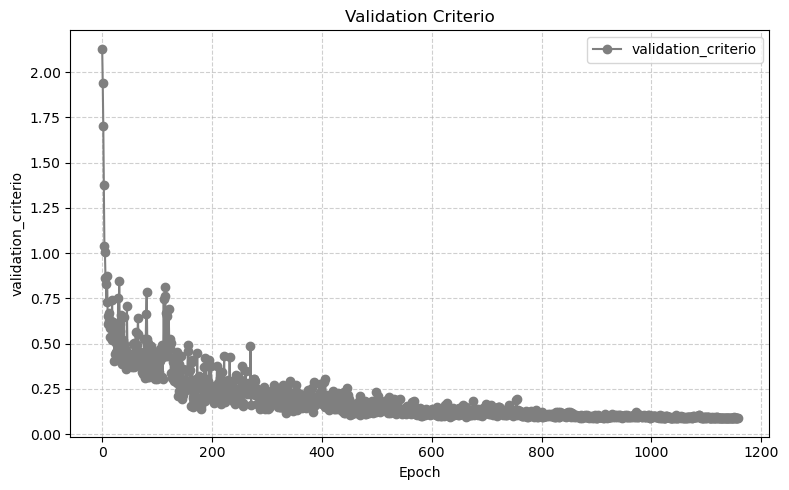

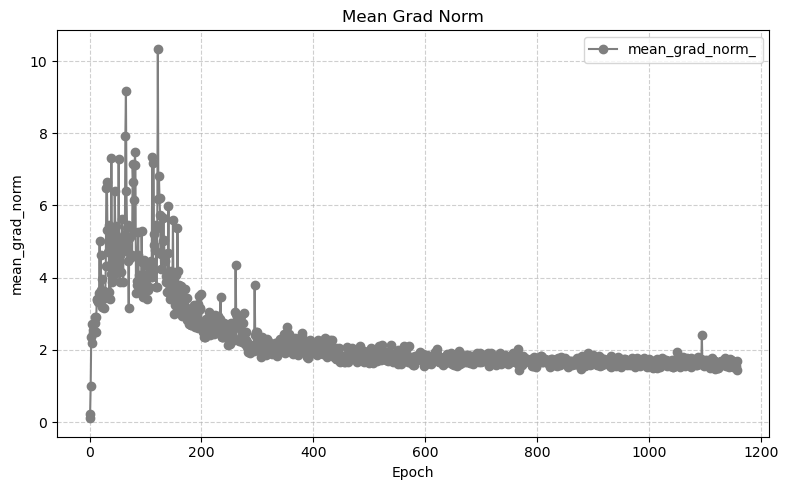

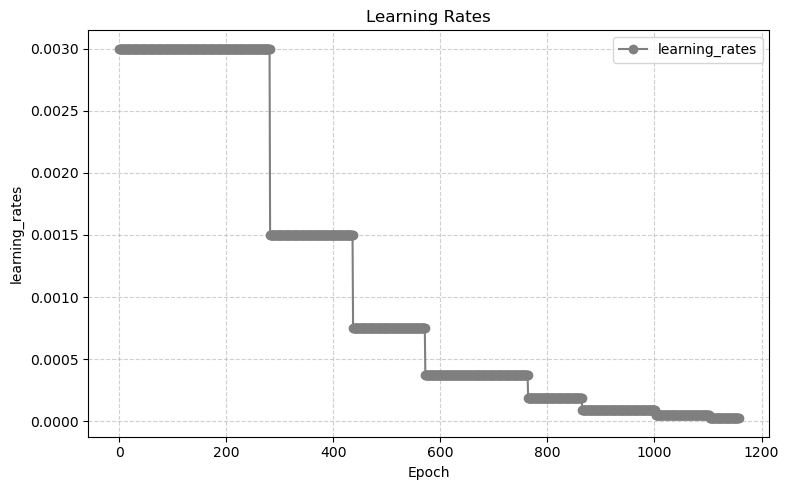

In [7]:
visualize_epoch_metrics(
 save_dir_path,
["val_prediction_loss_", "val_variance_loss_training_set", "val_prediction_loss_training_set",  "val_variance_loss_", "train_total_loss_", "train_hsic_loss_" , "validation_criterio", "mean_grad_norm_", "learning_rates"],
plot_on_same_graph=True,
verbose=True,
specific_epochs=None
)



📊 Processing directory: val_trajectories_data

For the epoch_1157 in val_trajectories_data the values are:
5: X_mean = 0.9059 ± 0.0522, U_mean = 0.8260 ± 0.0533 and energy=1.3666666666666667, phi0=0.7112530348369385
53: X_mean = 1.6256 ± 0.0375, U_mean = -2.4675 ± 0.0457 and energy=2.006666666666667, phi0=-2.4981901653384453
31: X_mean = 0.3123 ± 0.0250, U_mean = 0.2992 ± 0.0460 and energy=1.7133333333333338, phi0=0.2441816641299383

📊 Processing directory: val_train_set_trajectories_data

For the epoch_1157 in val_train_set_trajectories_data the values are:
61: X_mean = 0.4141 ± 0.0397, U_mean = 0.6813 ± 0.0539 and energy=2.1133333333333333, phi0=0.5187756048832214
54: X_mean = 1.3451 ± 0.0533, U_mean = -2.6279 ± 0.0406 and energy=2.02, phi0=-2.234453591452867
16: X_mean = 0.2176 ± 0.0198, U_mean = -1.7403 ± 0.0380 and energy=1.5133333333333334, phi0=-1.1130378924250106

📊 Processing directory: val_high_energy_trajectories_data
⚠️ Directory ./save_directory_noisy_full_pred_low_sample

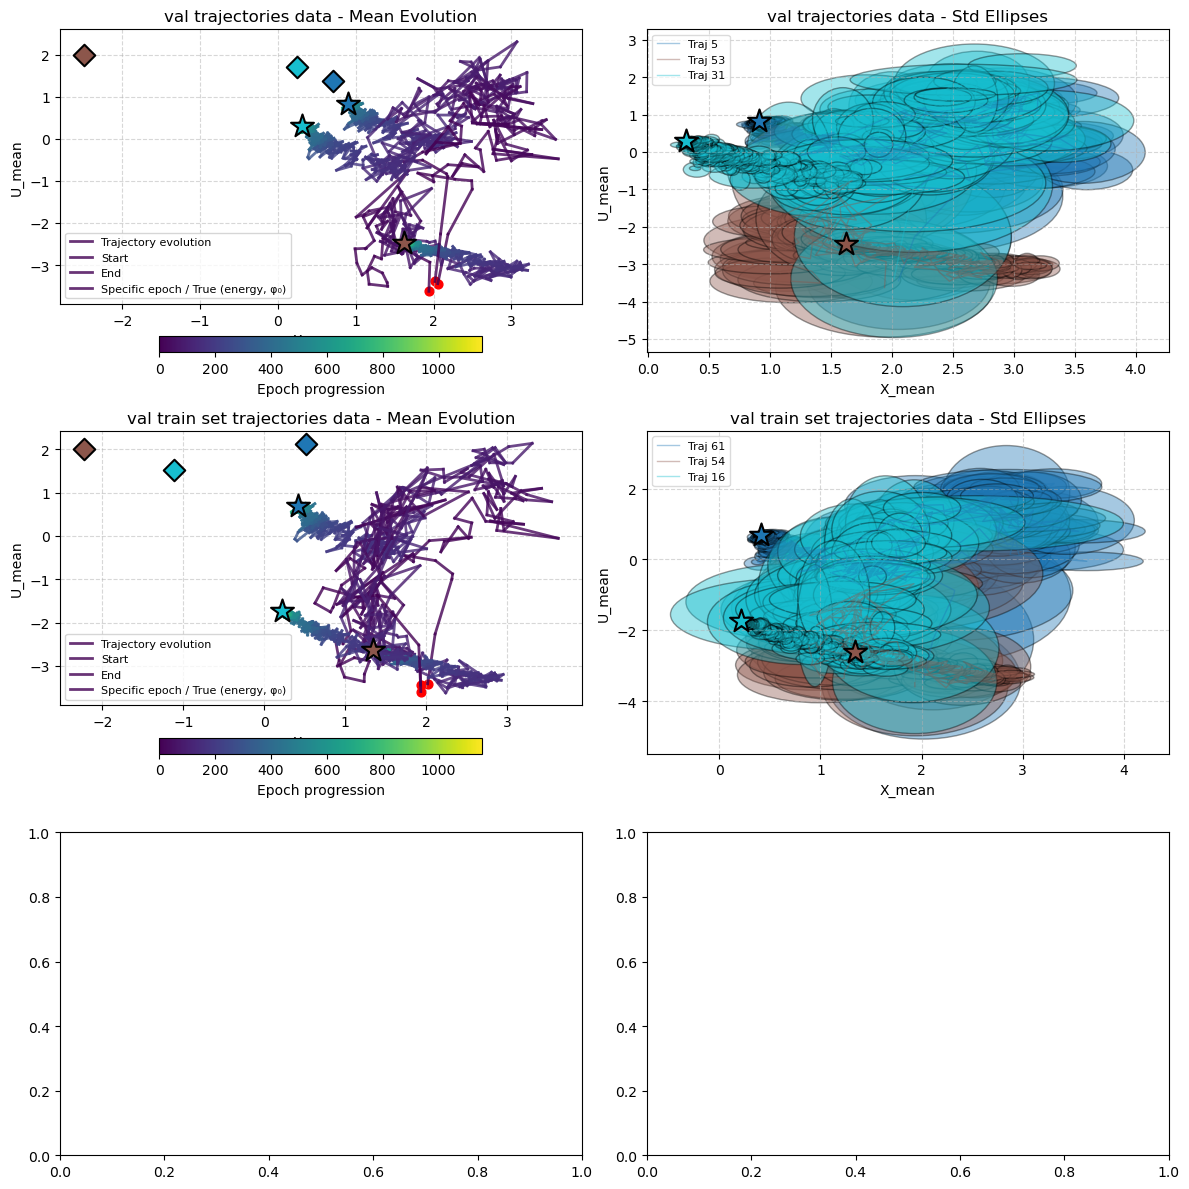


✅ Mean + Std (ellipse) visualization complete.


In [21]:
visualize_trajectory_movements_with_std_ellipses(save_dir_path, number_of_points_to_plot=3, right_plot_alpha=0.4, verbose=True, specific_epoch = "last", visualize_true_constants=True,train_id_df_added=train_id_df_low_samples_pendulum,val_id_df_added=val_id_df_low_samples_pendulum,val_id_df_high_energy_added=val_id_df_high_energy_low_samples_pendulum, pendulum=True)

In [22]:
val_differencies_df, val_train_differencies_set_df, val_high_energy_differencies_df = analyze_means_with_constants(
    save_dir_path=save_dir_path,
    specific_epoch="last",
    train_id_df_added=train_id_df_low_samples_pendulum,
    val_id_df_added=val_id_df_low_samples_pendulum,
    val_id_df_high_energy_added=val_id_df_high_energy_low_samples_pendulum,
    pendulum=True
)

📂 Using data from epoch: epoch_1157
⚠️ Warning: ./save_directory_noisy_full_pred_low_samples_pendulum_4/epoch_1157/val_high_energy_trajectories_data not found.
✅ Data extraction complete.


In [23]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['energy']),
    y=torch.Tensor(val_train_differencies_set_df['phi0']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.)

In [24]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['X_mean']),
    y=torch.Tensor(val_train_differencies_set_df['U_mean']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.)

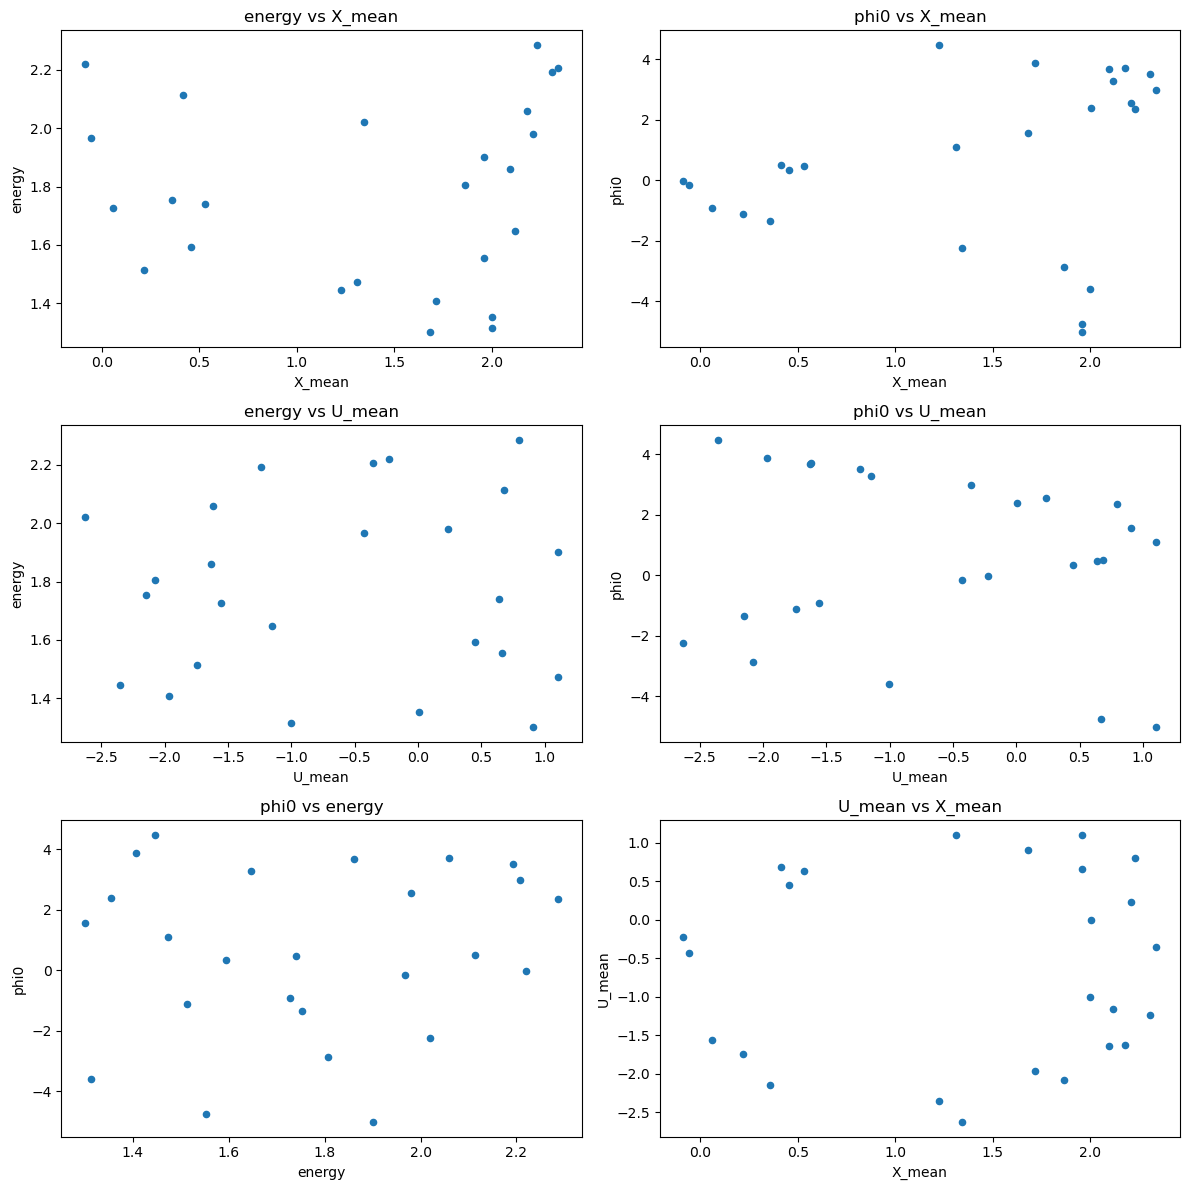

In [25]:
plot_differencies(val_train_differencies_set_df, pendulum=True)

📊 Analyzing 1158 epochs across 3 directories...

📁 Processing directory: val_trajectories_data

📁 Processing directory: val_train_set_trajectories_data

📁 Processing directory: val_high_energy_trajectories_data
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_pendulum_4/epoch_0/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_pendulum_4/epoch_1/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_pendulum_4/epoch_2/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_pendulum_4/epoch_3/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_pendulum_4/epoch_4/val_high_energy_trajectories_data not found. Skipping epoch.
⚠️ Directory ./save_directory_noisy_full_pred_low_samples_pendulum_4/epoch_5/val_high_energy_trajec

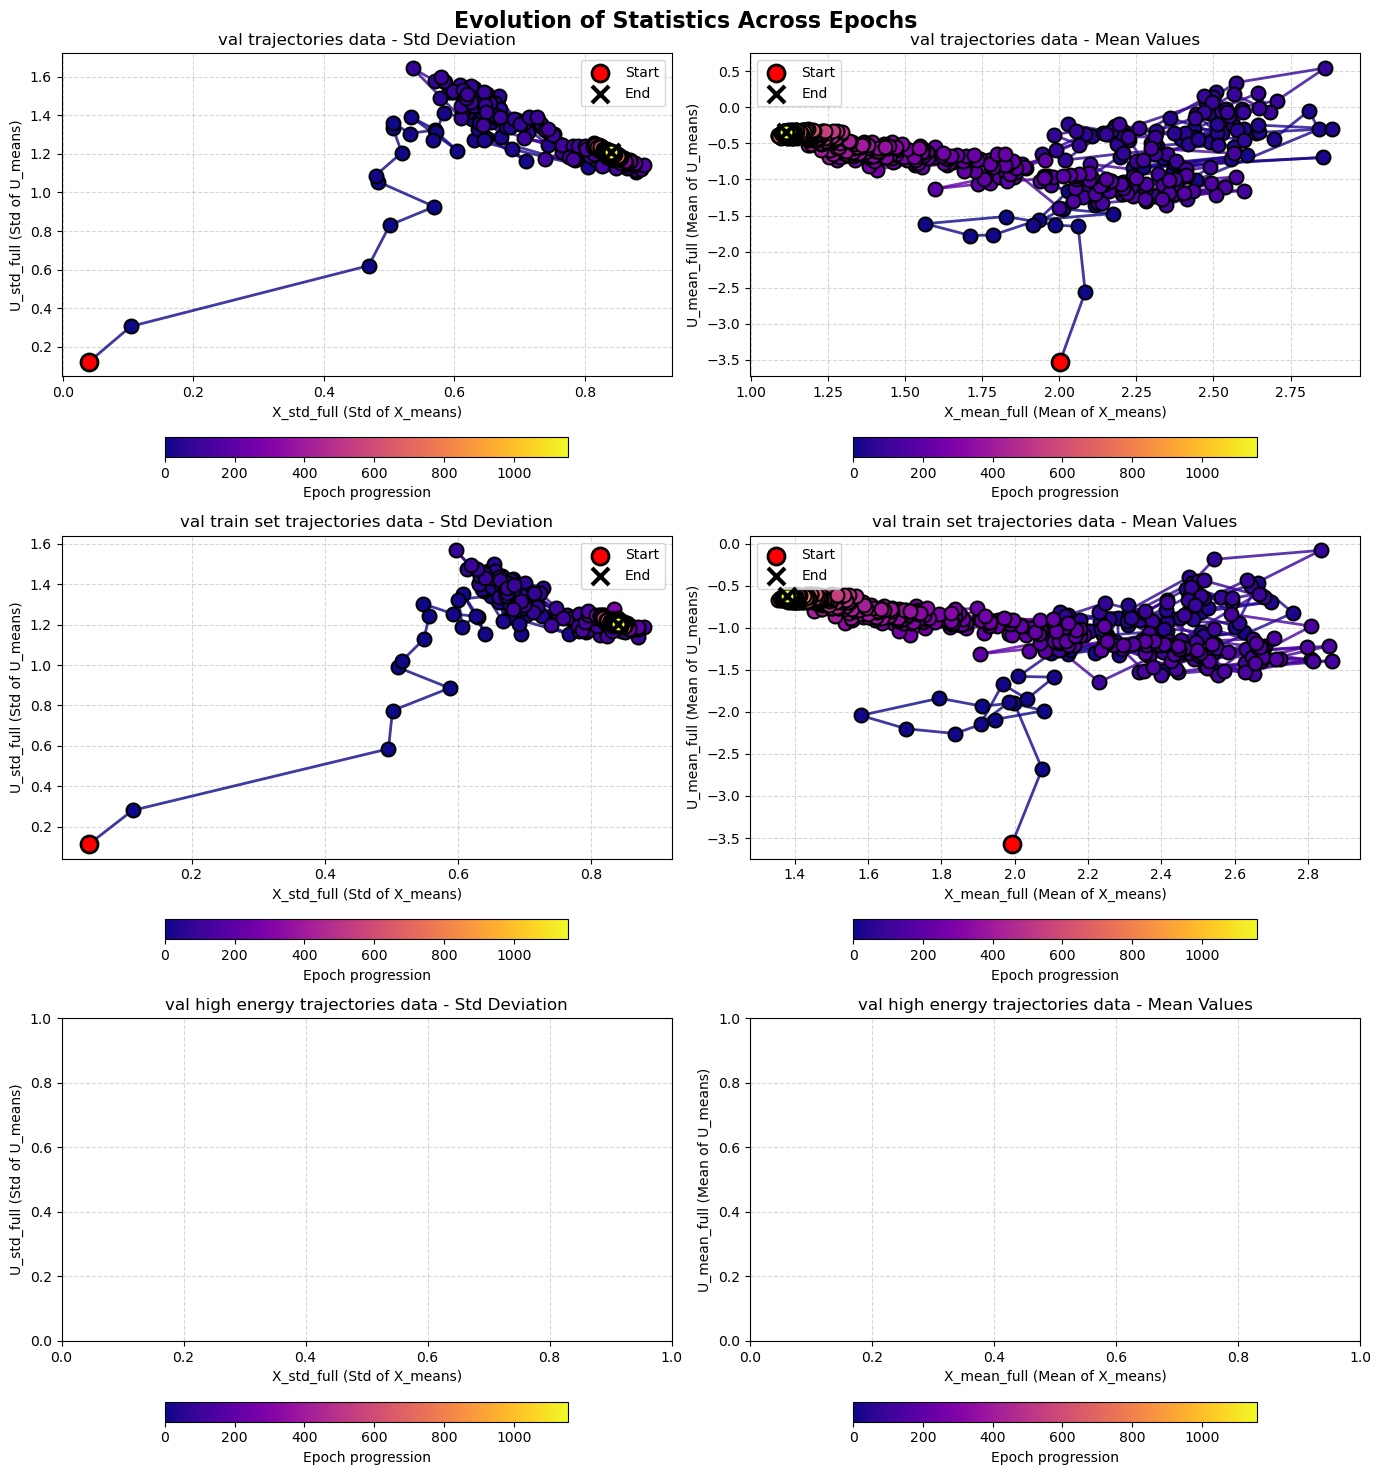

In [26]:
analyze_folders_means(save_dir_path, locate_epoch=None)

In [7]:
point_indexes_observed = [0]

In [8]:
tmax_list = []
for idx, row in train_id_df_low_samples_pendulum.iterrows():

    trajectory_id = int(row['trajectory_id'])
    start_index = int(row['start_index'])
    end_index = int(row['end_index'])
    
    test_trajectory_data = get_data_from_trajectory_id(train_id_df_low_samples_pendulum, train_df_low_samples_pendulum, trajectory_ids=trajectory_id)
    t = test_trajectory_data['t'].to_numpy(dtype=np.float32)
    tmax = max(t)
    tmax_list.append(tmax)
max_t_training = min(np.array(tmax_list))
dt = t[1] - t[0]

In [9]:
device = "cuda"
mapping_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
    n_layers=10,
        # MLP Architecture parameters
    hidden_dims= [33, 60, 32],
    n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
        
        # Activation parameters
    activation = 'gelu',
    activation_params = None,
    final_activation = None,   #Final layer activation function
    #final_activation_only_on_final_layer = True,
    tanh_wrapper = False,
        
        # Initialization parameters
    weight_init = 'orthogonal',
    weight_init_params = {'gain': 1},
    bias_init = 'zeros',
    bias_init_value = 0.0,
        
        
        # Architectural choices
    use_bias = True,
    use_layer_norm = False,
    
    # Input/Output parameters
    input_dim = 2,  # x or u and t
    output_dim = 1,  # scalar G or F
    a_eps_min= 0.5,  # Minimum value for a
    a_eps_max= 2,  # Maximum value for a  
    a_k= 0.1,

    step_1_a_mean_innit= 1.2,
    step_2_a_mean_innit= 1.2,
    std_to_mean_ratio_a_mean_init= 0.0,

    step_1_gamma_mean_innit= 0.5,
    step_2_gamma_mean_innit= 0.5,
    std_to_mean_ratio_gamma_mean_init= 0.0,

    step_1_c1_mean_innit= 0.0,
    step_2_c1_mean_innit= 0.0,
    std_to_mean_ratio_c1_mean_init= 1.0,

    step_1_c2_mean_innit= 0.0,
    step_2_c2_mean_innit= 0.0,
    std_to_mean_ratio_c2_mean_init= 1.0,

    bound_innit=0.0,
).to(device)

In [10]:


checkpoint_path = os.path.join(save_dir_path, "best_model.pt")

load_checkpoint(path=checkpoint_path, mapping_net=mapping_net, device=device, optimizer=None, scheduler=None)

inverse_net = InverseStackedHamiltonianNetwork(forward_network=mapping_net)


Successfully loaded model
Created inverse network with 10 reverse layers


/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:7003: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=devic

In [31]:
test_canonical_tranformation_on_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, compute_jacobian_functional_function=compute_jacobian_functional, compute_symplectic_product_function=compute_symplectic_product, check_canonical_transformation_function=check_canonical_transformation, tolerance=1e-4, test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, trajectory_id=20, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

For the mapping network:
✓ All 30 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 4.77e-07
For the inverse network:
✓ All 30 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 3.58e-07


In [32]:
print(f"Number of parameters are: {count_parameters(mapping_net)}, with number of training samples: {train_df_low_samples_pendulum.shape[0]}\nThat is a ratio of parameters/samples of: {count_parameters(mapping_net)/train_df_low_samples_pendulum.shape[0]}")

Number of parameters are: 82560, with number of training samples: 750
That is a ratio of parameters/samples of: 110.08


   num_observed_points  mean_loss
0                    1   0.072773
1                    2   0.062397
2                    3   0.059897
3                    4   0.056320
4                    5   0.049717
5                    6   0.047617
6                    7   0.045521
7                    8   0.042696
8                    9   0.039948
9                   10   0.039017


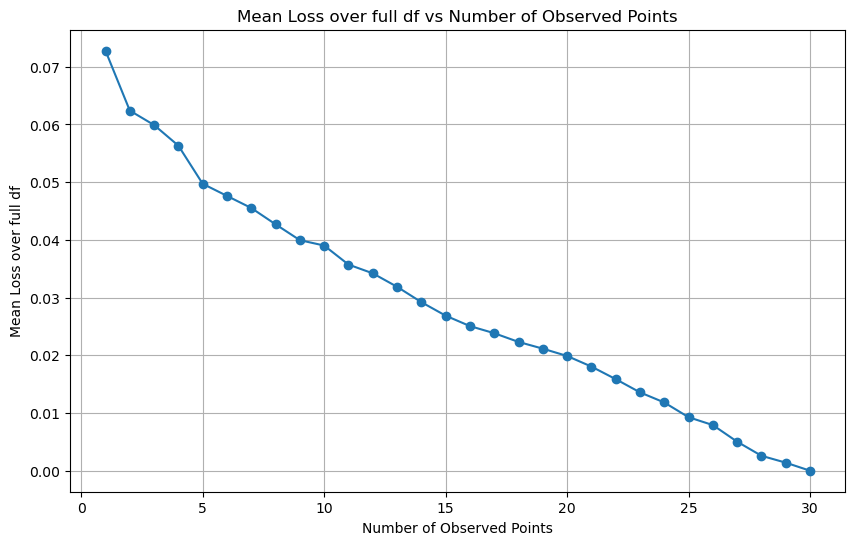

In [33]:
val_loss_per_points_df = test_model_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

   num_observed_points  mean_variance
0                    1       0.000000
1                    2       0.003207
2                    3       0.001841
3                    4       0.003009
4                    5       0.002665
5                    6       0.002820
6                    7       0.002764
7                    8       0.003517
8                    9       0.004137
9                   10       0.004183


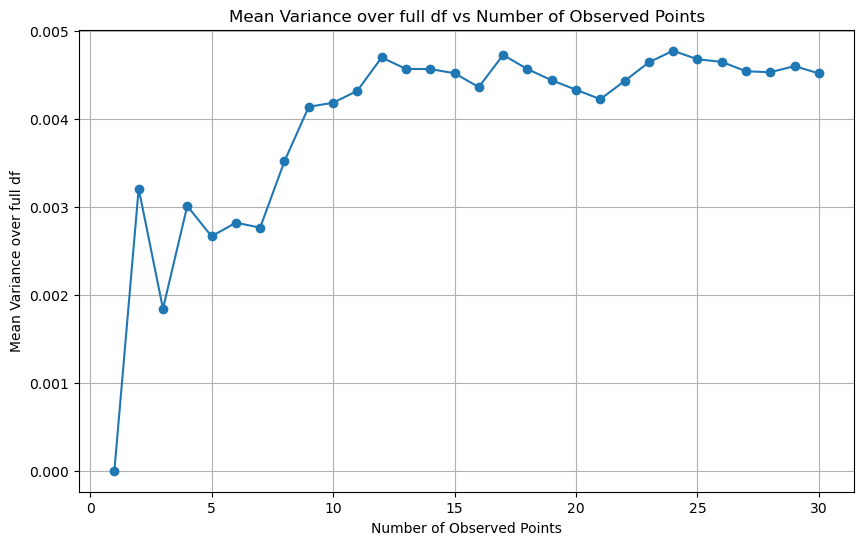

In [34]:
val_variance_per_points_df = test_model_variance_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id ,test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, mapping_net=mapping_net ,device=device)

In [12]:
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ---------------------------------------------------------
# 1. PREPARE FIXED ARGUMENTS
# ---------------------------------------------------------
# These arguments never change during the optimization.
# We pack them here to keep the objective function clean.
fixed_args = {
    "get_data_from_trajectory_id_function": get_data_from_trajectory_id,
    "prediction_loss_function": prediction_loss_euclidean,
    "test_id_df": val_id_df_low_samples_pendulum,
    "test_df": val_df_low_samples_pendulum,
    "mapping_net": mapping_net,
    "inverse_net": inverse_net,
    "device": device,
    "point_indexes_observed": point_indexes_observed,
    "recreate_and_plot_phase_space": False,
    "plot_specific_portion": 0.26,
    "connect_points": False,
    "plot_trajectories_subsample": 0.4,
    "max_t_training": max_t_training,
    "efficiently": False,
    "method": "gaussian_mixture_simple",
    "threshold": 1.0,
    "dt": dt,
    "alpha":1.0,
    "gamma":1.0,
    "cluster_weight_threshold": 0.4,
    "search_range_lower_pct": 0.1,  # Assuming this is fixed
    "verbose":False
}

# ---------------------------------------------------------
# 2. DEFINE THE OBJECTIVE FUNCTION
# ---------------------------------------------------------
def objective(trial):
    """
    This function runs ONE experiment. 
    Optuna provides the 'trial' object which we use to select params.
    """
    

    # B. Conditional Logic (The Bayesian part)
    # Optuna's sampler will learn that 'threshold' is only relevant when efficiently=False

        
    # suggest_float(name, low, high)

    search_range_upper_pct_param = trial.suggest_float("search_range_upper_pct", 0.2, 0.8) 
    max_n_components_param = trial.suggest_int("max_n_components", 2, 10)

    # C. Run your actual function
    # We handle exceptions so one bad run doesn't crash the whole study
    try:
        _, mean_loss = test_model_in_all_trajectories_in_df(
            search_range_upper_pct = search_range_upper_pct_param,
            max_n_components = max_n_components_param,
            **fixed_args
        )
    except Exception as e:
        print(f"Trial failed: {e}")
        # Return infinity so Optuna knows this was a terrible run
        return float('inf')

    # D. Return the value we want to MINIMIZE
    return mean_loss

# ---------------------------------------------------------
# 3. RUN THE OPTIMIZATION (THE STUDY)
# ---------------------------------------------------------
print("Starting Bayesian Optimization...")

# Create the study. We want to 'minimize' the loss.
study = optuna.create_study(direction="minimize")

# n_trials=20 means it will run your function 20 times. 
# Increase this to 50 or 100 if you have time.
study.optimize(objective, n_trials=30, show_progress_bar=True)

# ---------------------------------------------------------
# 4. VIEW RESULTS
# ---------------------------------------------------------
print("-" * 30)
print("BEST RESULTS FOUND:")
print(f"Best Mean Loss: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

# If you want to see all trials as a DataFrame:
df_results = study.trials_dataframe()
# print(df_results)

Starting Bayesian Optimization...


Best trial: 15. Best value: 0.0796987: 100%|██████████| 30/30 [4:01:43<00:00, 483.44s/it]  

------------------------------
BEST RESULTS FOUND:
Best Mean Loss: 0.07969865202903748
Best Hyperparameters: {'search_range_upper_pct': 0.21004741205686503, 'max_n_components': 9}


    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
2               2  1.326667         0.090436              0.078516
6               6  1.380000         0.105428              0.089747
9               9  1.420000         0.083304              0.069907
12             12  1.460000         0.079264              0.065599
15             15  1.500000         0.050408              0.041158
17             17  1.526667         0.064376              0.052101
24             24  1.620000         0.094093              0.073927
25             25  1.633333         0.039259              0.030718
28             28  1.673333         0.066949              0.051755
29             29  1.686667         0.091176              0.070205
30             30  1.700000         0.038720              0.029697
36             36  1.780000         0.049801              0.037327
39             39  1.820000         0.036381              0.026968
40             40  1.833333         0.063349              0.04

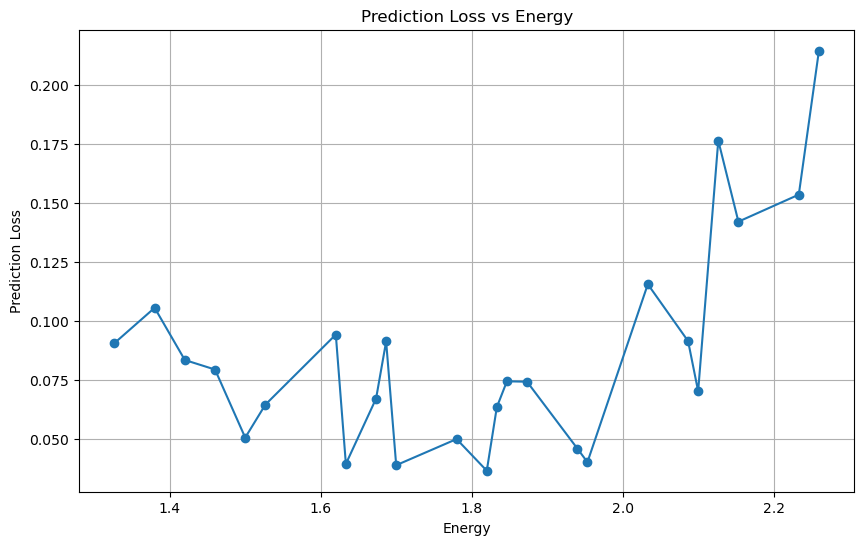

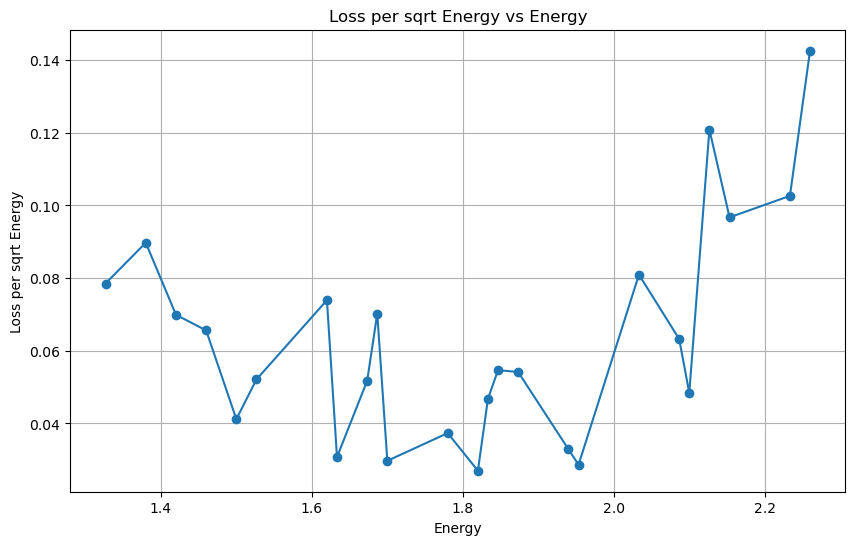

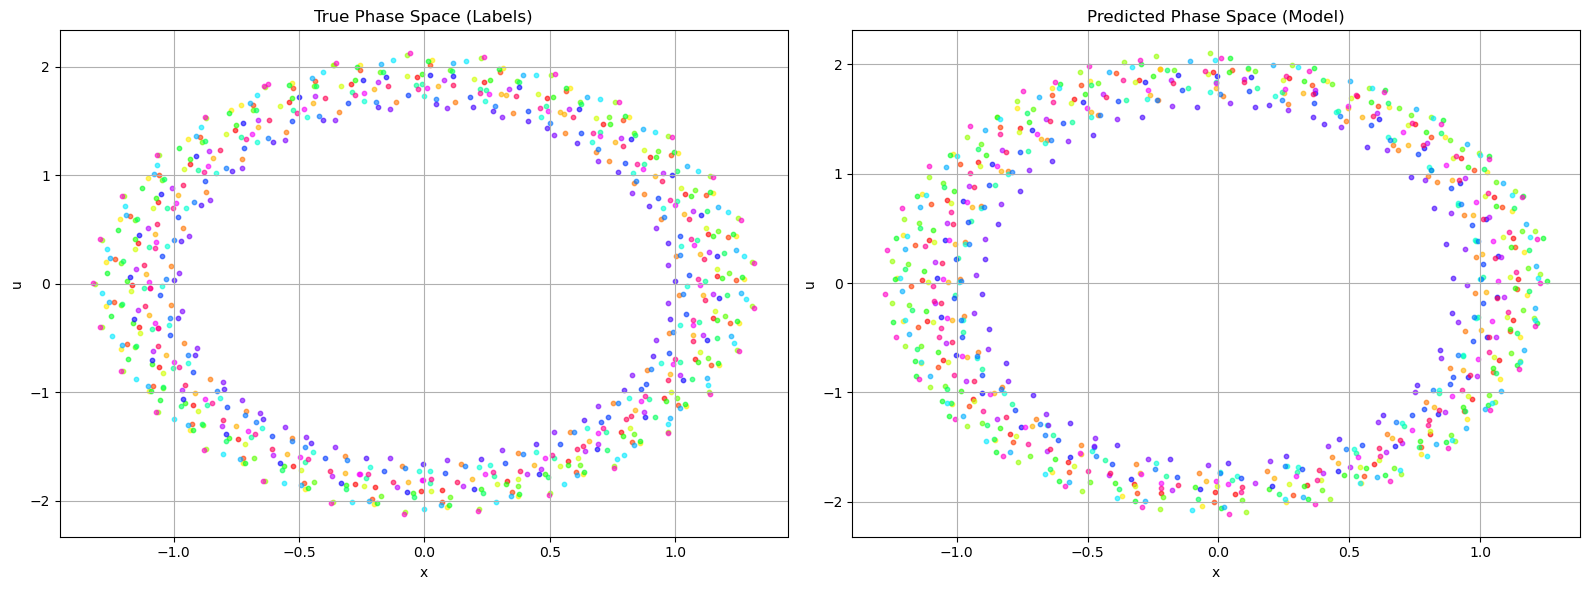

In [ ]:
prediction_test_df, mean_prediction_loss_test, pred_test_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples_pendulum, test_df=test_df_low_samples_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=1.0, max_t_training=max_t_training, efficiently=True,method = "mahalanobis",  threshold=1.0, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=4, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
2               2  1.326667         0.104699              0.090899
6               6  1.380000         0.085103              0.072444
9               9  1.420000         0.079672              0.066859
12             12  1.460000         0.091915              0.076070
15             15  1.500000         0.061793              0.050453
17             17  1.526667         0.074311              0.060143
24             24  1.620000         0.070809              0.055633
25             25  1.633333         0.053077              0.041530
28             28  1.673333         0.058969              0.045586
29             29  1.686667         0.043132              0.033211
30             30  1.700000         0.033091              0.025379
36             36  1.780000         0.040992              0.030725
39             39  1.820000         0.034399              0.025498
40             40  1.833333         0.063554              0.04

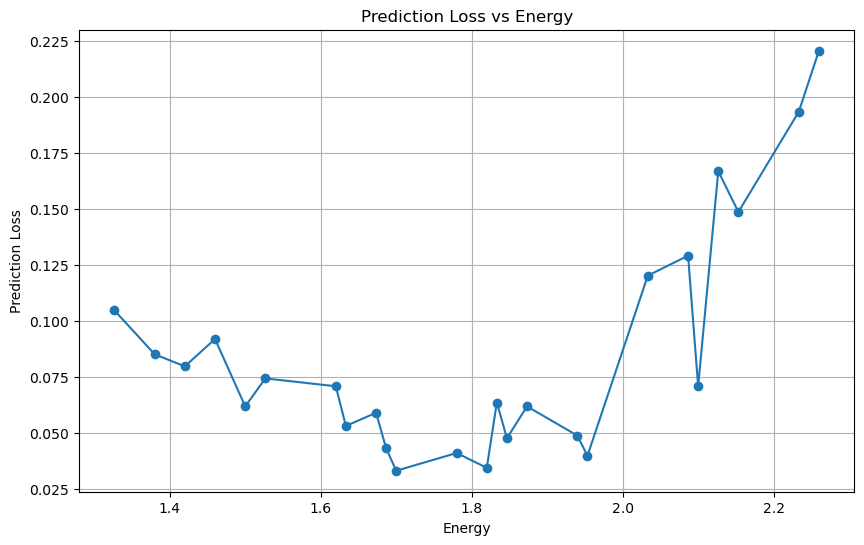

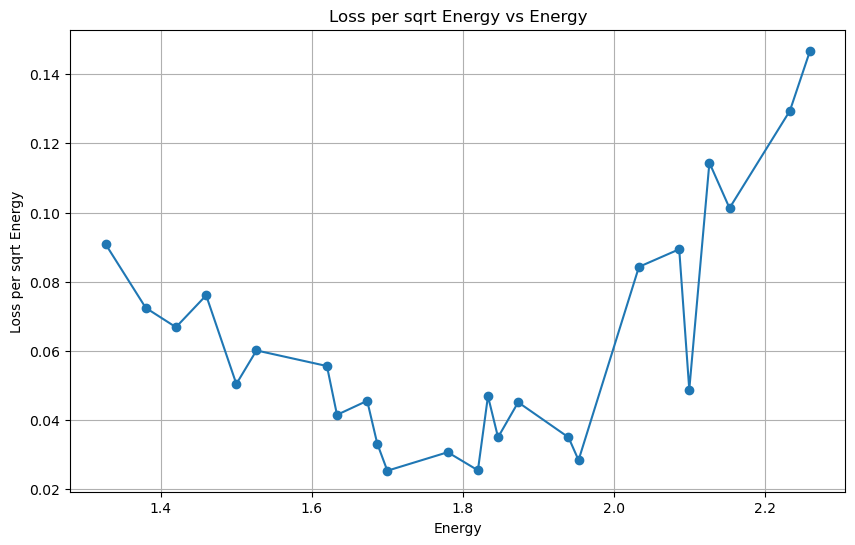

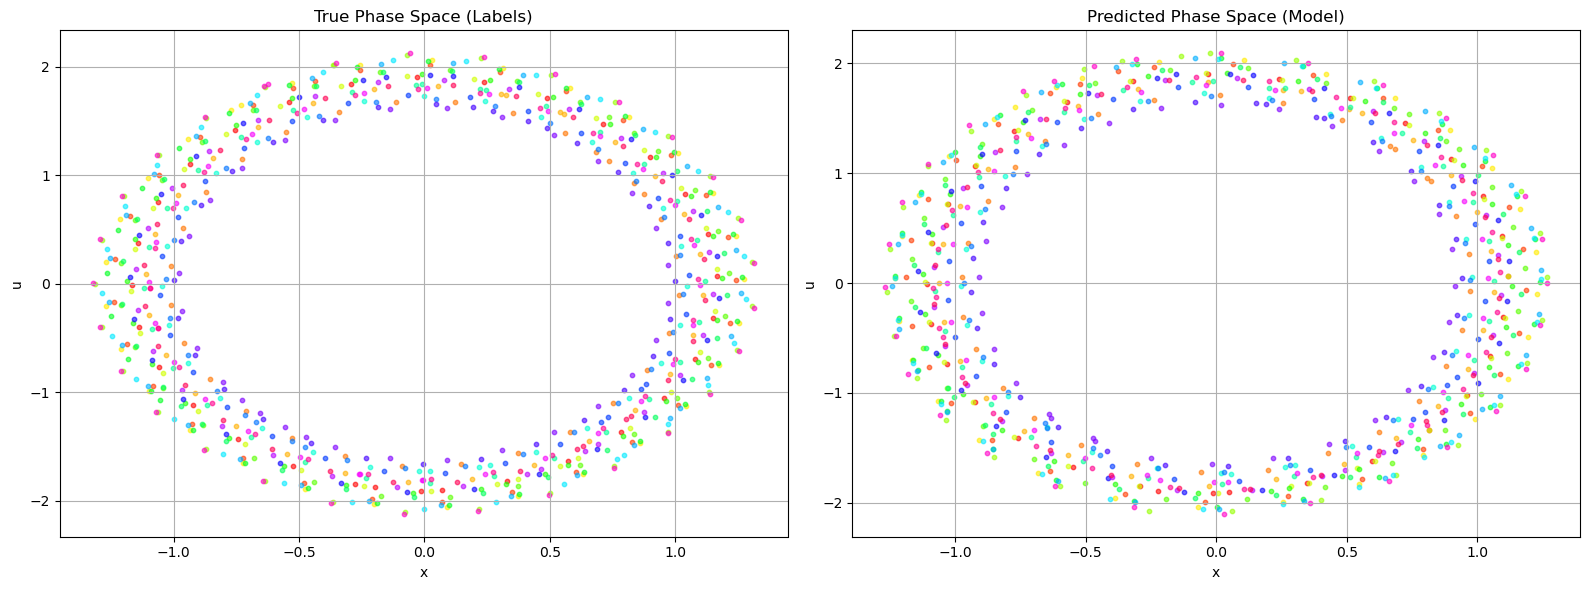

In [20]:
prediction_test_ensemble_df, mean_prediction_loss_test_ensemble, pred_test_ensemble_df = test_model_in_all_trajectories_in_df(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
prediction_loss_function=prediction_loss_euclidean, 
test_id_df=test_id_df_low_samples_pendulum, 
test_df=test_df_low_samples_pendulum, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
recreate_and_plot_phase_space=True, 
plot_specific_portion=1.0, 
connect_points=False, 
plot_trajectories_subsample=1.0, 
max_t_training=max_t_training, 
efficiently=False, 
method="gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=9, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.21004741205686503, 
verbose=True)

/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:11277: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


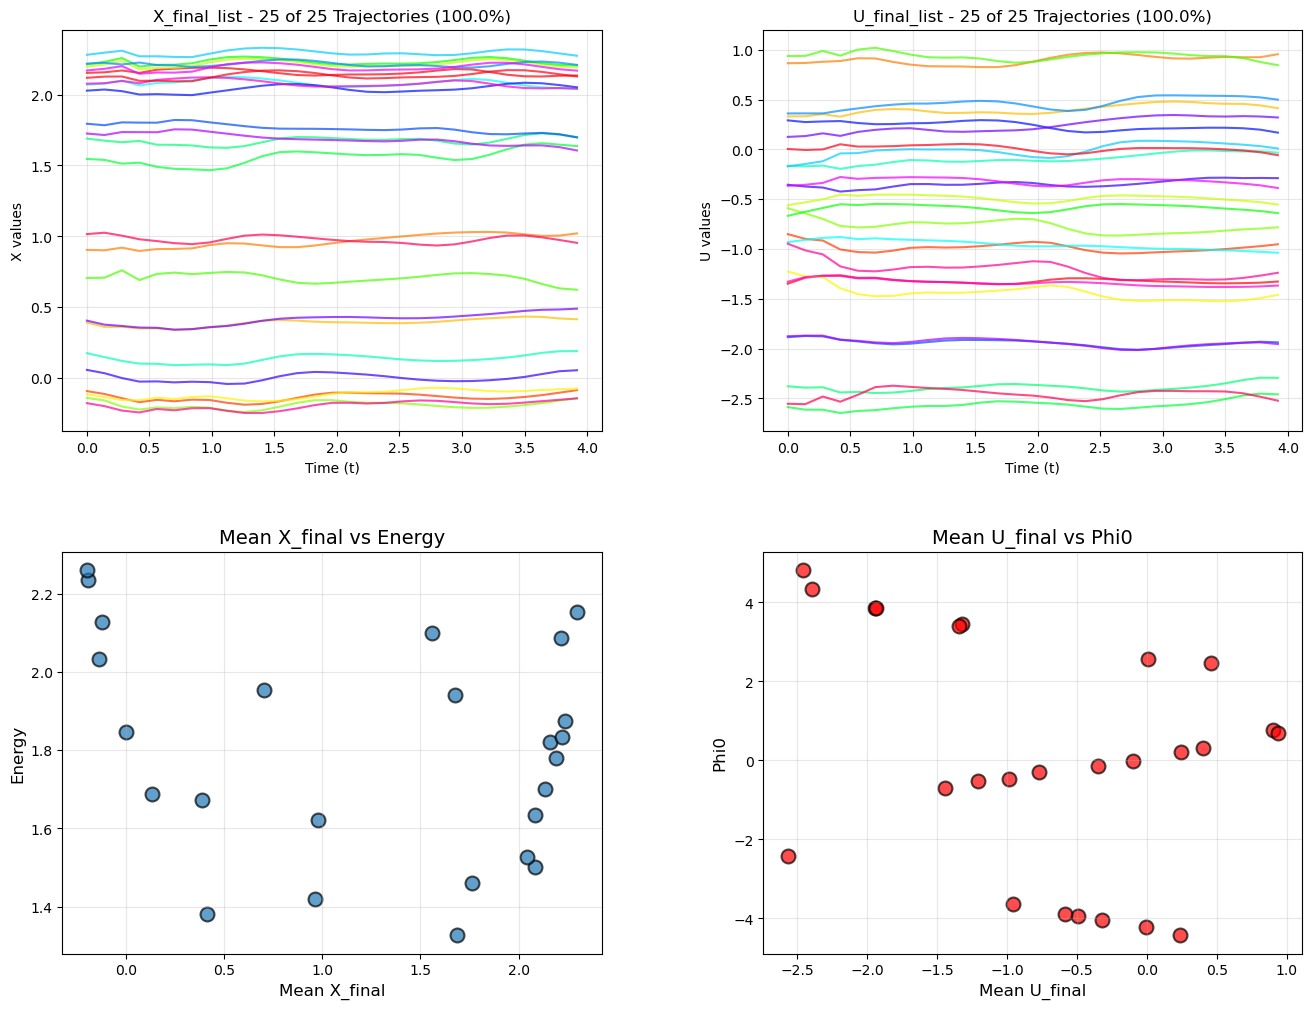

In [38]:
plot_all_transformed_trajectories(
    test_id_df_low_samples_pendulum, 
    test_df_low_samples_pendulum, 
    get_data_from_trajectory_id_function=get_data_from_trajectory_id,mapping_net=mapping_net, device=device,
    max_t_training=max_t_training,
    option_1=False,
    only_plot_percentage=1.0
)

In [14]:
trajectory_id_to_show_test=39
period_test = test_id_df_low_samples_pendulum[test_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test]['period'].values[0] if test_id_df_low_samples_pendulum[test_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test]['motion_type'].values[0] == "oscillating" else 0.0

trajectory_id_to_show_test_ensemble=39
period_test_ensemble = test_id_df_low_samples_pendulum[test_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_ensemble]['period'].values[0] if test_id_df_low_samples_pendulum[test_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_ensemble]['motion_type'].values[0] == "oscillating" else 0.0


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 1
inverse_net calls: 1
Total forward passes: 2
Observed time points: [0.]


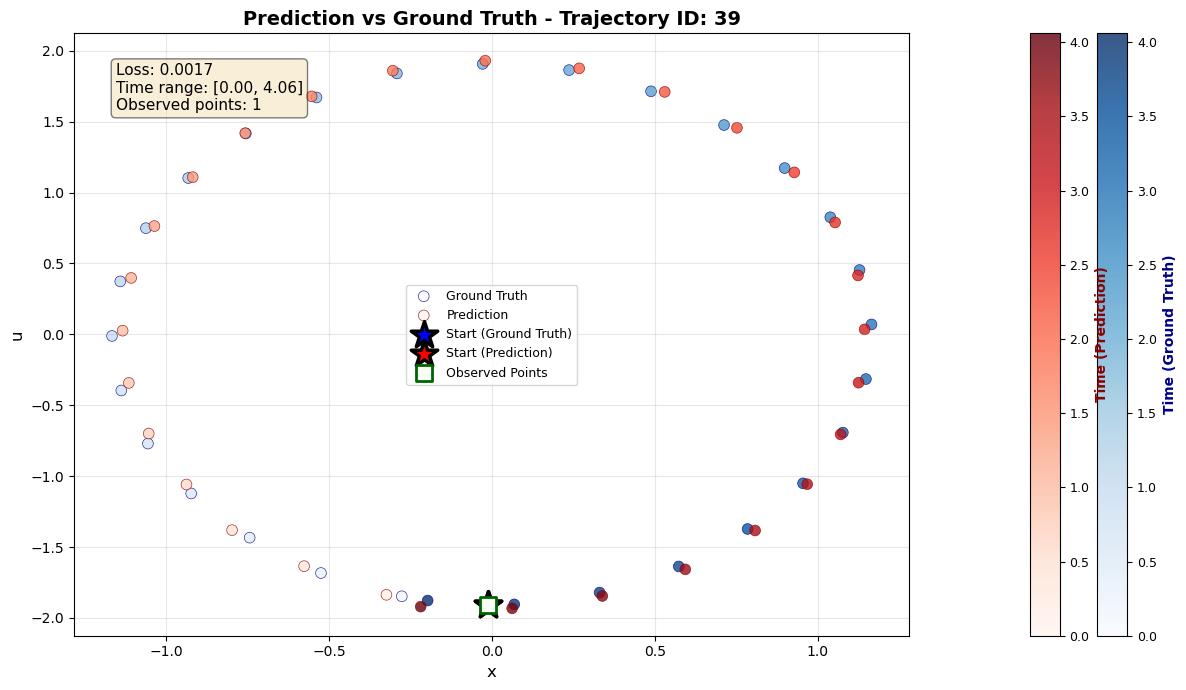

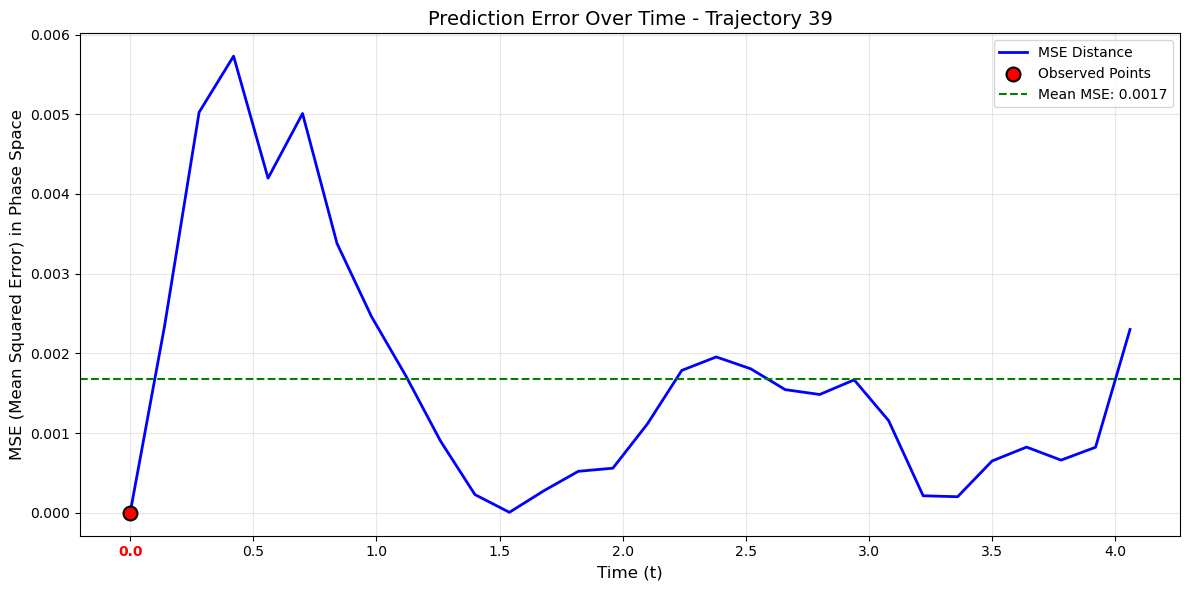

In [40]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_low_samples_pendulum, test_df=test_df_low_samples_pendulum, trajectory_id=trajectory_id_to_show_test, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=None, show_zeroings=False, show_period=False, period=period_test, max_t_training=max_t_training, efficiently=True, method = "mahalanobis", threshold=1.0, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=4, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True, plot=True)

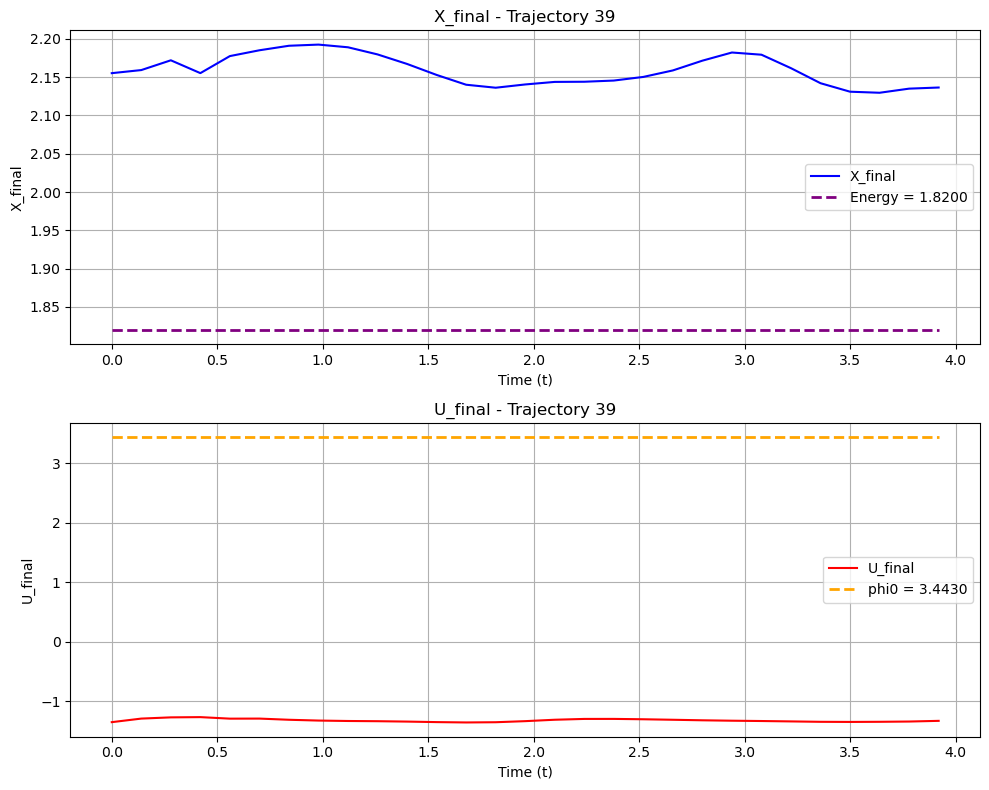

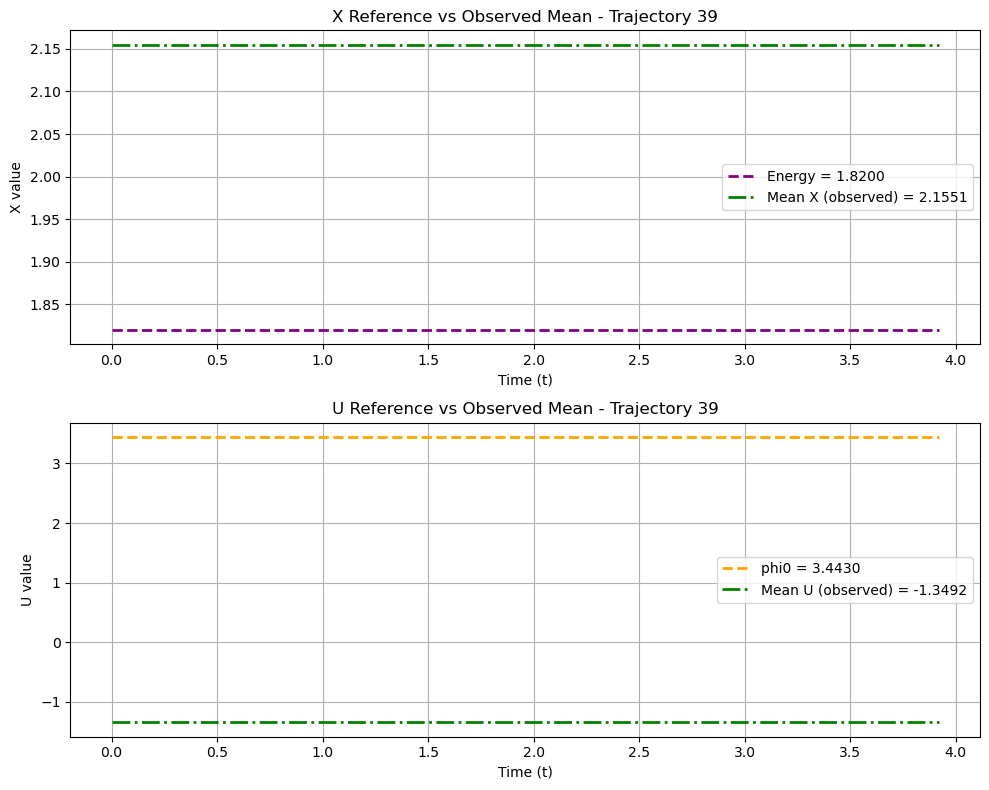

In [41]:
plot_transformed_trajectory(test_id_df_low_samples_pendulum, test_df_low_samples_pendulum, trajectory_id_to_show_test, 
                                get_data_from_trajectory_id, mapping_net,
                                max_t_training, device, option_1=False,
                                point_indexes_observed=point_indexes_observed)

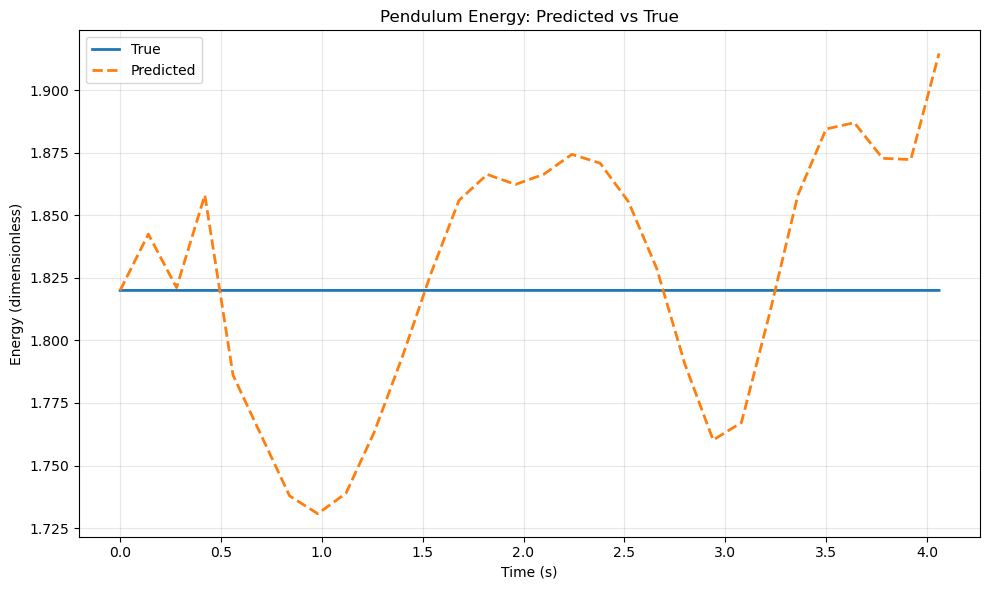

In [ ]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id, 
test_id_df_low_samples_pendulum, 
test_df_low_samples_pendulum, 
trajectory_id_to_show_test_ensemble, 
mapping_net, 
inverse_net, 
device, 
point_indexes_observed, 
max_t_training,
efficiently=True,
method = "mahalanobis",
threshold=1.0,
dt=0.1,
alpha=1.0,
gamma=1.0,
cluster_weight_threshold=0.4,
max_n_components=5,
search_range_lower_pct=0.5,
search_range_upper_pct=0.6,
case="ideal_pendulum",
length=1.0, k=1, mass=1, g=3.0, constant=2.4,
verbose=False,
)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 3
inverse_net calls: 89
Total forward passes: 92
Coverage: 100.0%
Observed time points: [0.]


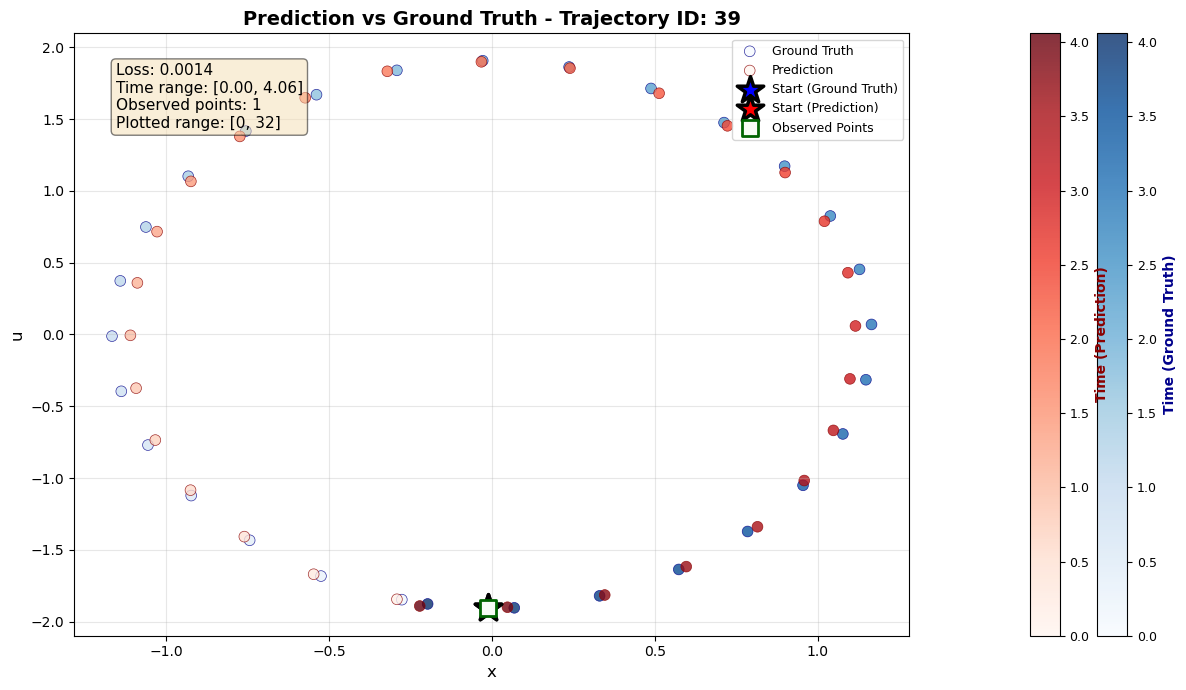

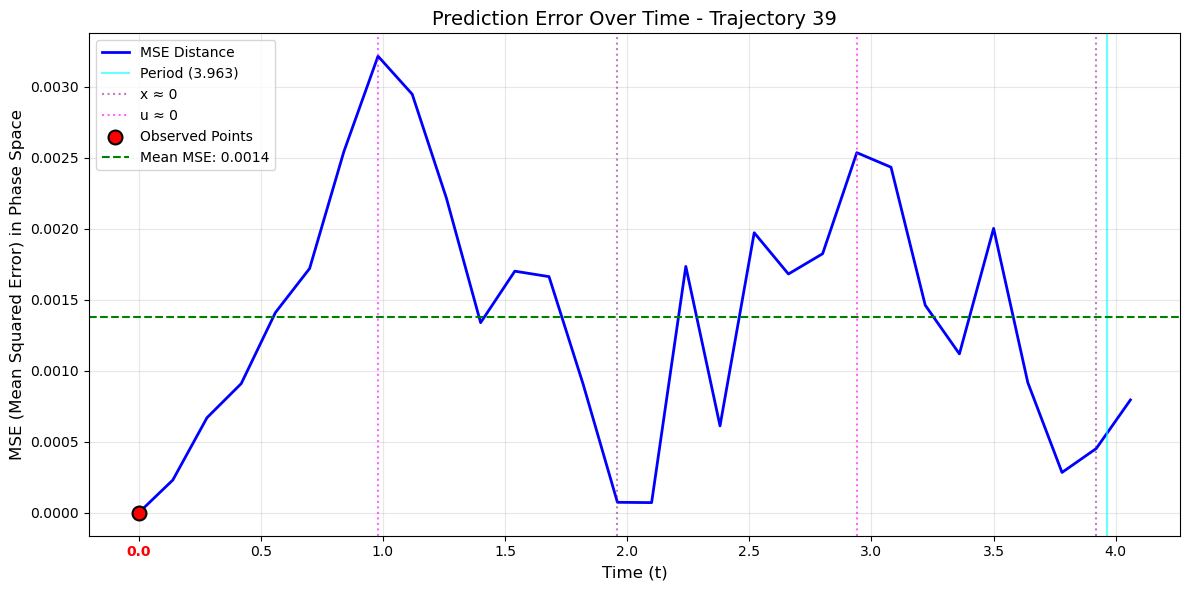

In [15]:
test_model_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
loss_type="mse", 
test_id_df=test_id_df_low_samples_pendulum, 
test_df=test_df_low_samples_pendulum, 
trajectory_id=trajectory_id_to_show_test_ensemble, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
connect_points=False, 
portion_to_visualize=[0,32], 
show_zeroings=True, 
show_period=True, 
period=period_test_ensemble, 
max_t_training=max_t_training, 
efficiently=False, 
method="gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=9, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.21004741205686503, 
verbose=True)

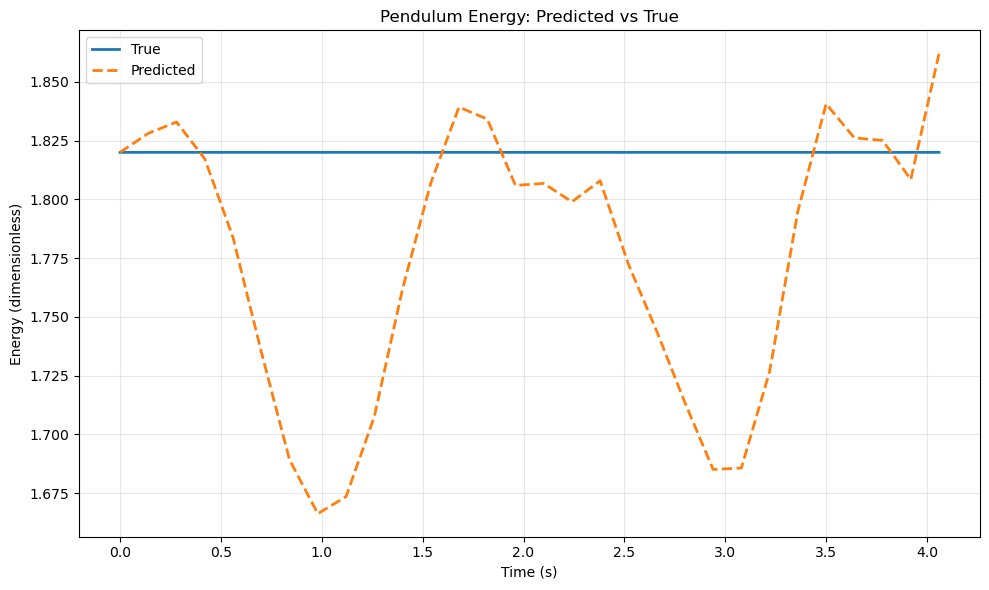

In [16]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id, 
test_id_df_low_samples_pendulum, 
test_df_low_samples_pendulum, 
trajectory_id_to_show_test_ensemble, 
mapping_net, 
inverse_net, 
device, 
point_indexes_observed, 
max_t_training,
efficiently=False, 
method="gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=9, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.21004741205686503, 
case="ideal_pendulum",
length=1.0, k=1, mass=1, g=3.0, constant=2.4,
verbose=False,
)

   num_observed_points  mean_variance
0                    1       0.000000
1                    2       0.002365
2                    3       0.001873
3                    4       0.000936
4                    5       0.000624
5                    6       0.001407
6                    7       0.001203
7                    8       0.000902
8                    9       0.001434
9                   10       0.001983


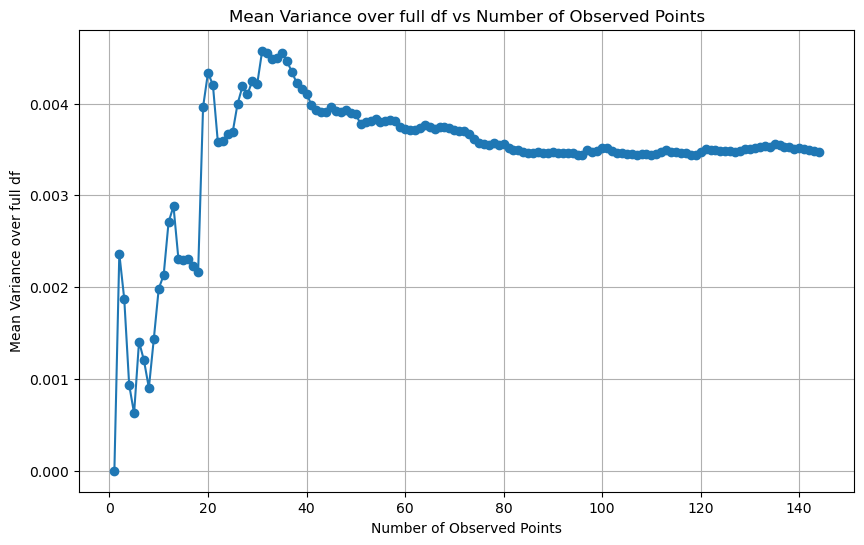

In [12]:
variance_with_varying_observed_points_multiple_periods_df = test_model_variance_with_varying_observed_points_multiple_periods(
get_data_from_trajectory_id,
test_id_df_low_samples_multiple_periods_pendulum,
test_df_low_samples_multiple_periods_pendulum,
mapping_net,
max_t_training,
device)

    trajectory_id  energy  prediction_loss  loss_per_sqrt_energy
0               0    1.30         0.472816              0.414687
1               1    1.35         0.451667              0.388733
2               2    1.40         0.405954              0.343094
3               3    1.45         0.474391              0.393960
4               4    1.50         0.361515              0.295176
5               5    1.55         0.305230              0.245166
6               6    1.60         0.322804              0.255199
7               7    1.65         0.248507              0.193462
8               8    1.70         0.207348              0.159029
9               9    1.75         0.177566              0.134228
10             10    1.80         0.141442              0.105424
11             11    1.85         0.110002              0.080875
12             12    1.90         0.218766              0.158710
13             13    1.95         0.124589              0.089220
14             14    2.00

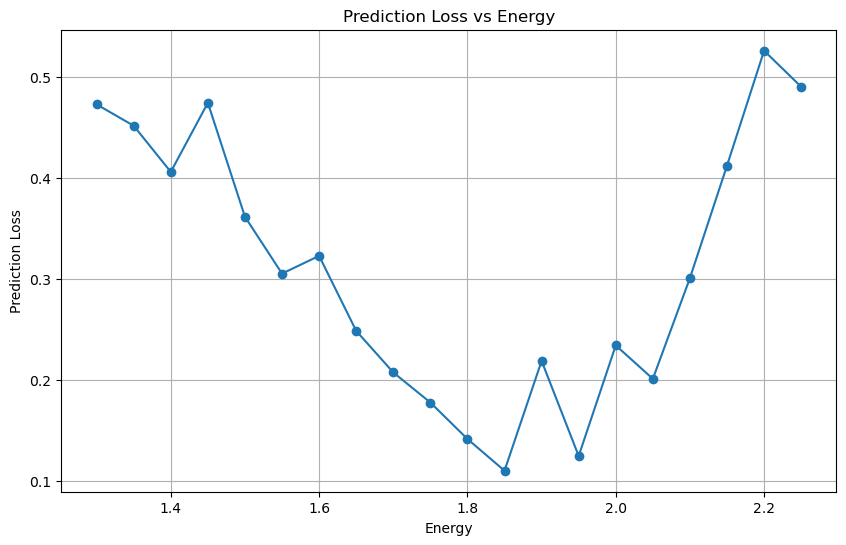

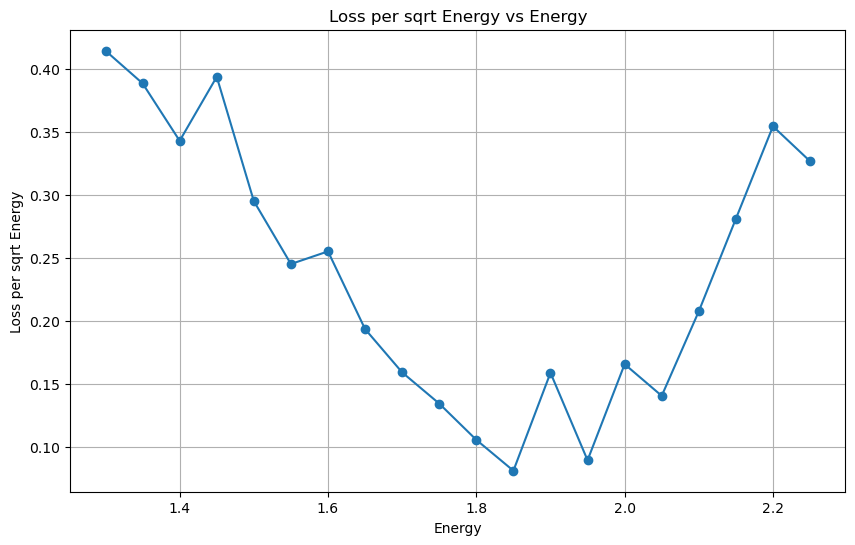

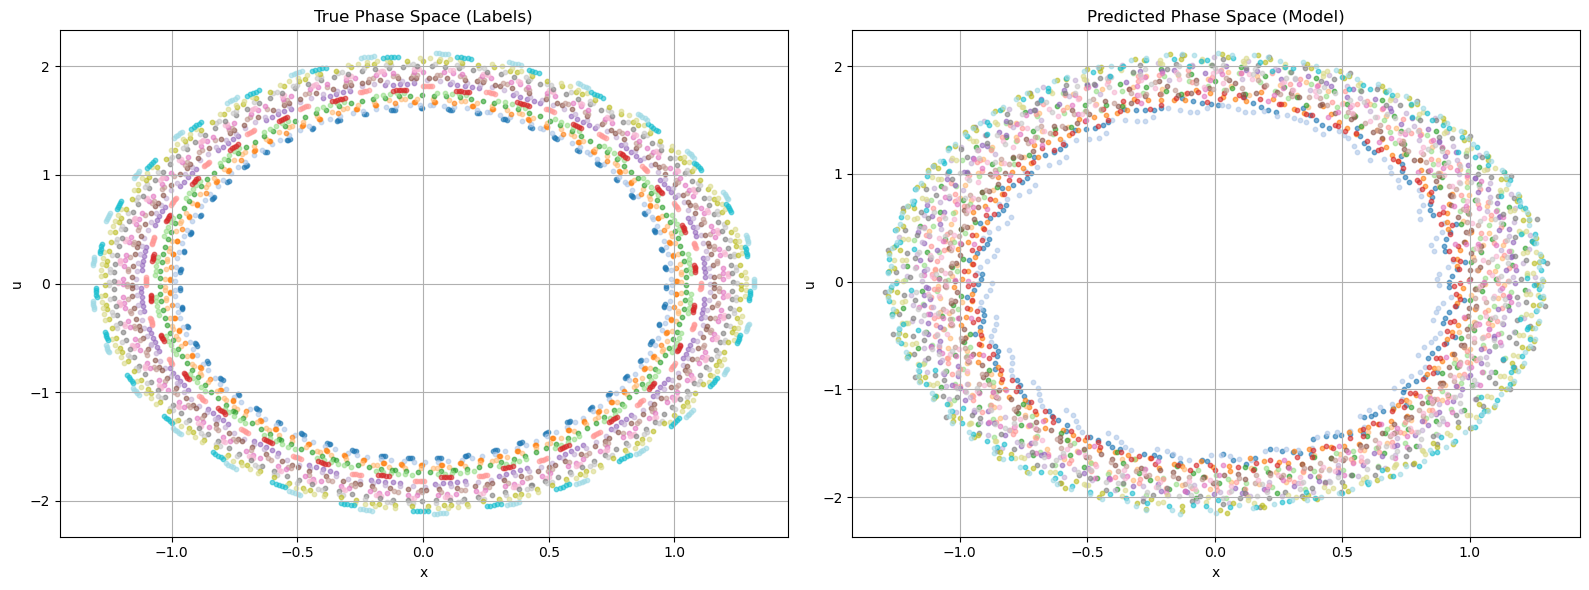

In [11]:
prediction_test_df_multiple_periods, mean_prediction_loss_test_multiple_periods, pred_test_df_multiple_periods = test_model_in_all_trajectories_in_df(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
prediction_loss_function=prediction_loss_euclidean, 
test_id_df=test_id_df_low_samples_multiple_periods_pendulum, 
test_df=test_df_low_samples_multiple_periods_pendulum, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
recreate_and_plot_phase_space=True, 
plot_specific_portion=1.0, 
connect_points=False, 
plot_trajectories_subsample=1.0, 
max_t_training=max_t_training, 
efficiently=True, 
method = "mahalanobis", 
threshold=1.0, dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=4, 
search_range_lower_pct=0.5, 
search_range_upper_pct=0.6, 
verbose=True)

    trajectory_id  energy  prediction_loss  loss_per_sqrt_energy
0               0    1.30         0.491114              0.430735
1               1    1.35         0.408775              0.351818
2               2    1.40         0.380129              0.321268
3               3    1.45         0.357257              0.296685
4               4    1.50         0.297436              0.242855
5               5    1.55         0.228240              0.183327
6               6    1.60         0.162223              0.128249
7               7    1.65         0.183881              0.143151
8               8    1.70         0.122219              0.093738
9               9    1.75         0.083812              0.063356
10             10    1.80         0.074103              0.055233
11             11    1.85         0.110121              0.080963
12             12    1.90         0.131127              0.095130
13             13    1.95         0.267773              0.191756
14             14    2.00

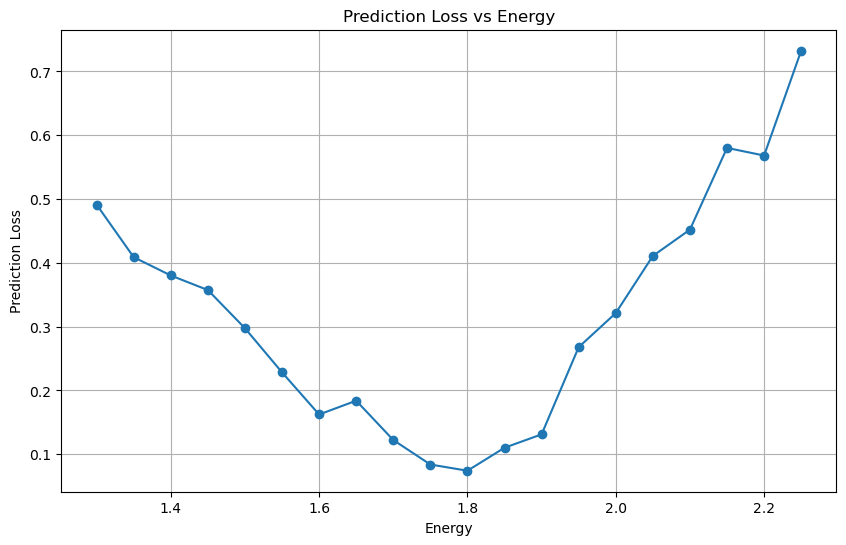

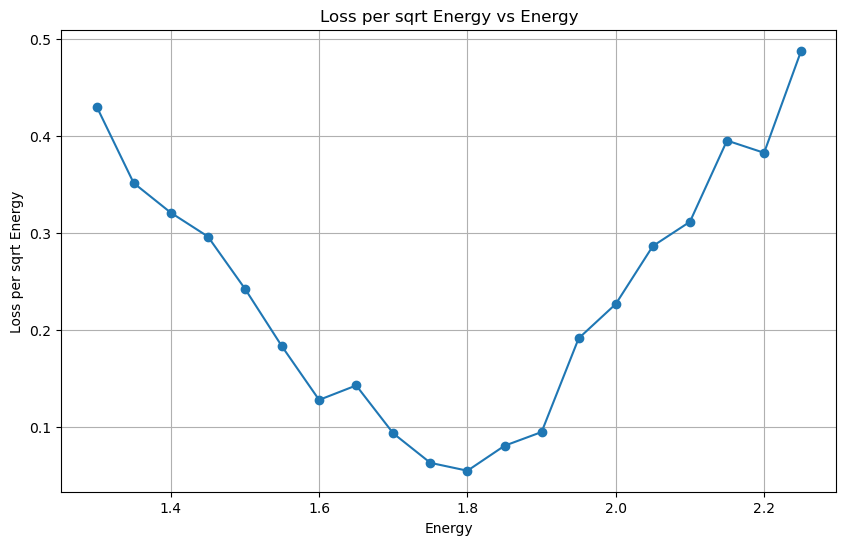

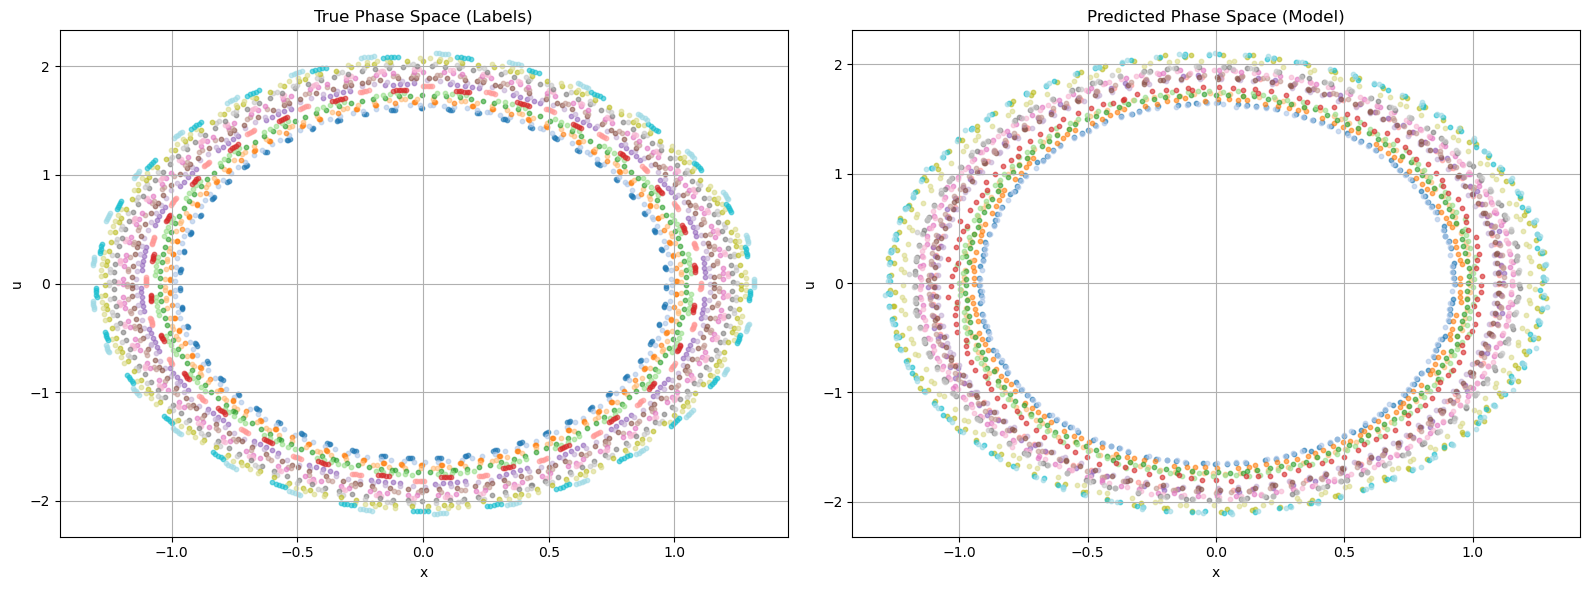

In [12]:
prediction_test_ensemble_df_multiple_periods, mean_prediction_loss_test_ensemble_multiple_periods, pred_test_ensemble_df_multiple_periods = test_model_in_all_trajectories_in_df(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
prediction_loss_function=prediction_loss_euclidean, 
test_id_df=test_id_df_low_samples_multiple_periods_pendulum, 
test_df=test_df_low_samples_multiple_periods_pendulum, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
recreate_and_plot_phase_space=True, 
plot_specific_portion=1.0, 
connect_points=False, 
plot_trajectories_subsample=1.0, 
max_t_training=max_t_training, 
efficiently=False, 
method="gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=9, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.21004741205686503, 
verbose=True)

/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:11412: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


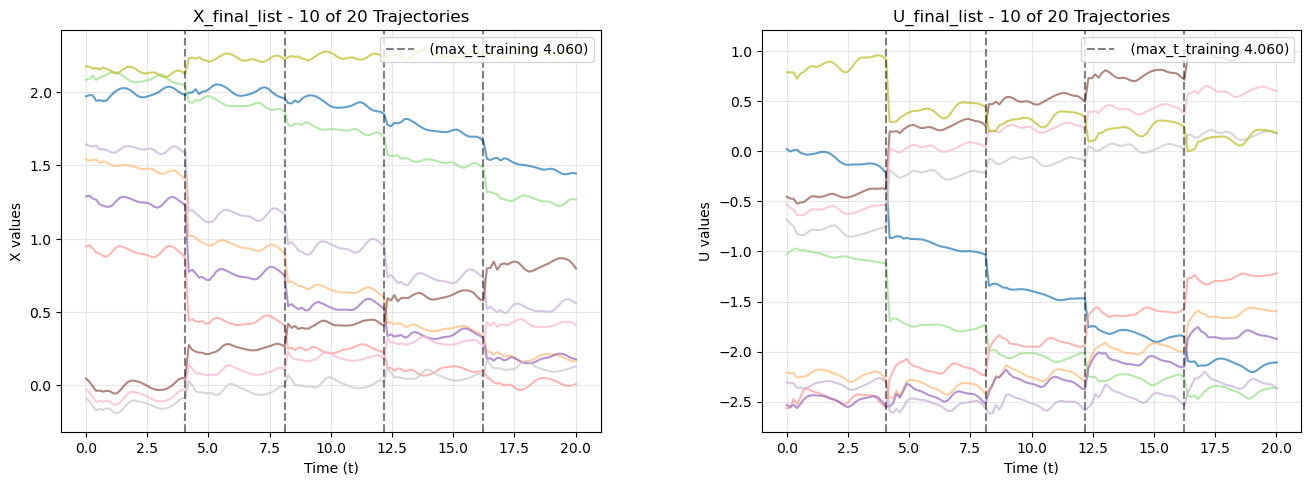

In [16]:
plot_all_transformed_trajectories_multiple_periods(
    test_id_df_low_samples_multiple_periods_pendulum, 
    test_df_low_samples_multiple_periods_pendulum, 
    get_data_from_trajectory_id_function=get_data_from_trajectory_id,mapping_net=mapping_net, device=device,
    max_t_training=max_t_training,
    only_plot_percentage=0.5
)

In [12]:
trajectory_id_test_multiple_periods = 11
period_test_multiple_periods = test_id_df_low_samples_multiple_periods_pendulum[test_id_df_low_samples_multiple_periods_pendulum['trajectory_id']==trajectory_id_test_multiple_periods]['period'].values[0] if test_id_df_low_samples_multiple_periods_pendulum[test_id_df_low_samples_multiple_periods_pendulum['trajectory_id']==trajectory_id_test_multiple_periods]['motion_type'].values[0] == "oscillating" else 0.0

trajectory_id_test_multiple_periods_ensemble = 11
period_test_multiple_periods_ensemble = test_id_df_low_samples_multiple_periods_pendulum[test_id_df_low_samples_multiple_periods_pendulum['trajectory_id']==trajectory_id_test_multiple_periods_ensemble]['period'].values[0] if test_id_df_low_samples_multiple_periods_pendulum[test_id_df_low_samples_multiple_periods_pendulum['trajectory_id']==trajectory_id_test_multiple_periods_ensemble]['motion_type'].values[0] == "oscillating" else 0.0


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 5
inverse_net calls: 5
Total forward passes: 10
Observed time points: [0.]


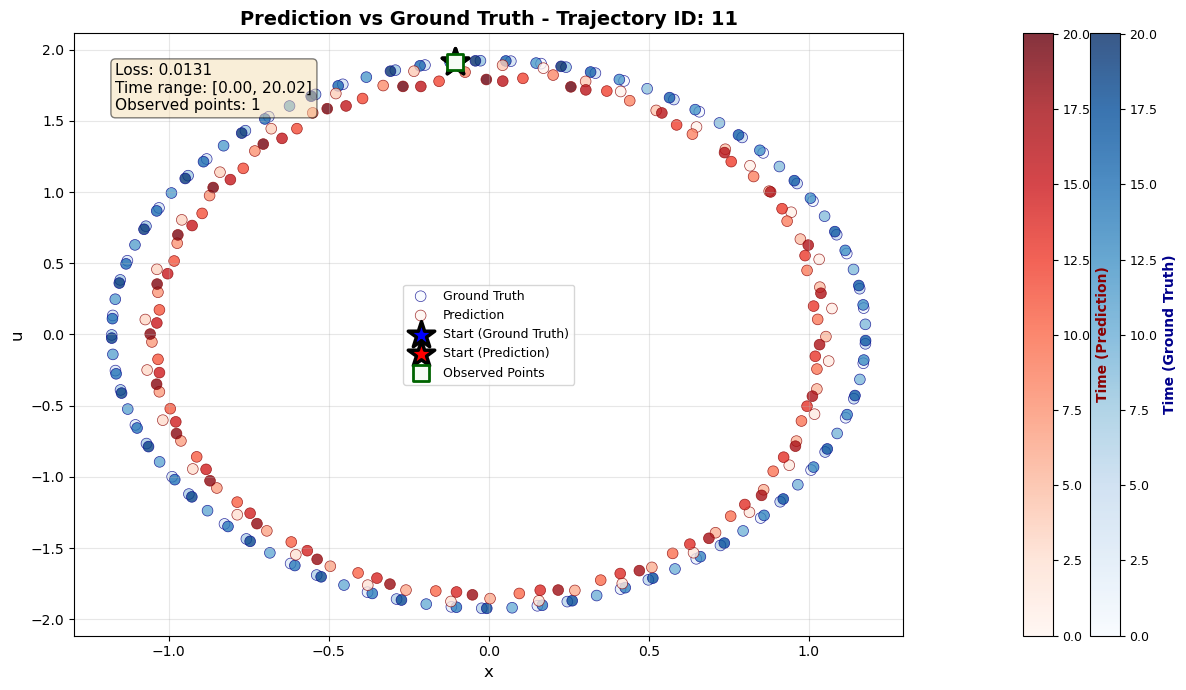

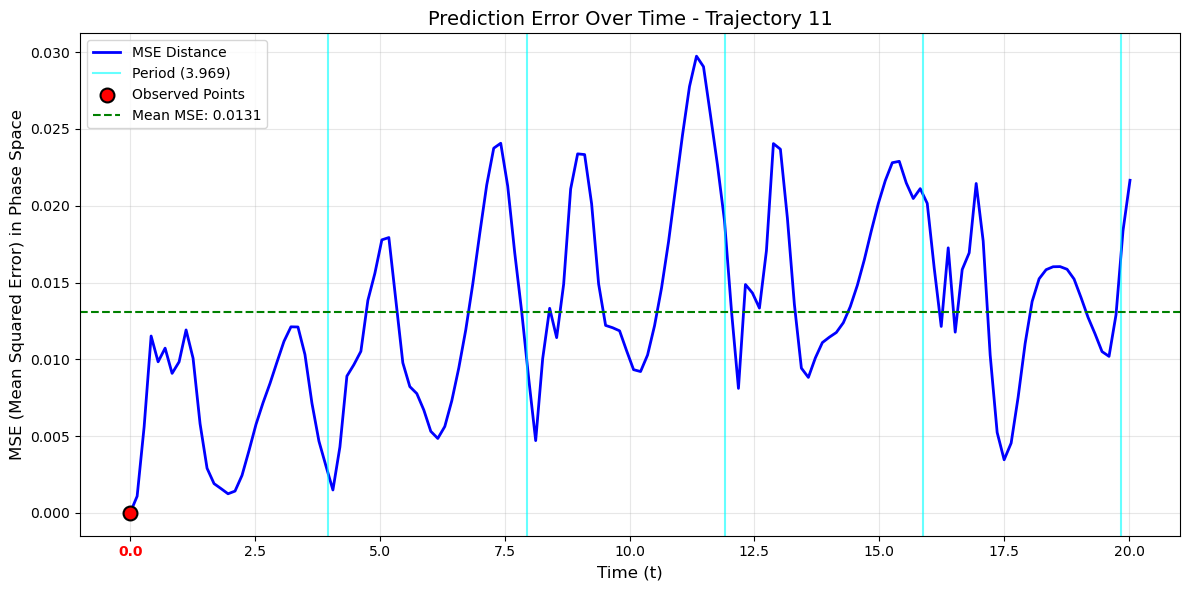

In [50]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_low_samples_multiple_periods_pendulum, test_df=test_df_low_samples_multiple_periods_pendulum, trajectory_id=trajectory_id_test_multiple_periods, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=None, show_zeroings=False, show_period=True, period=period_test_multiple_periods, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

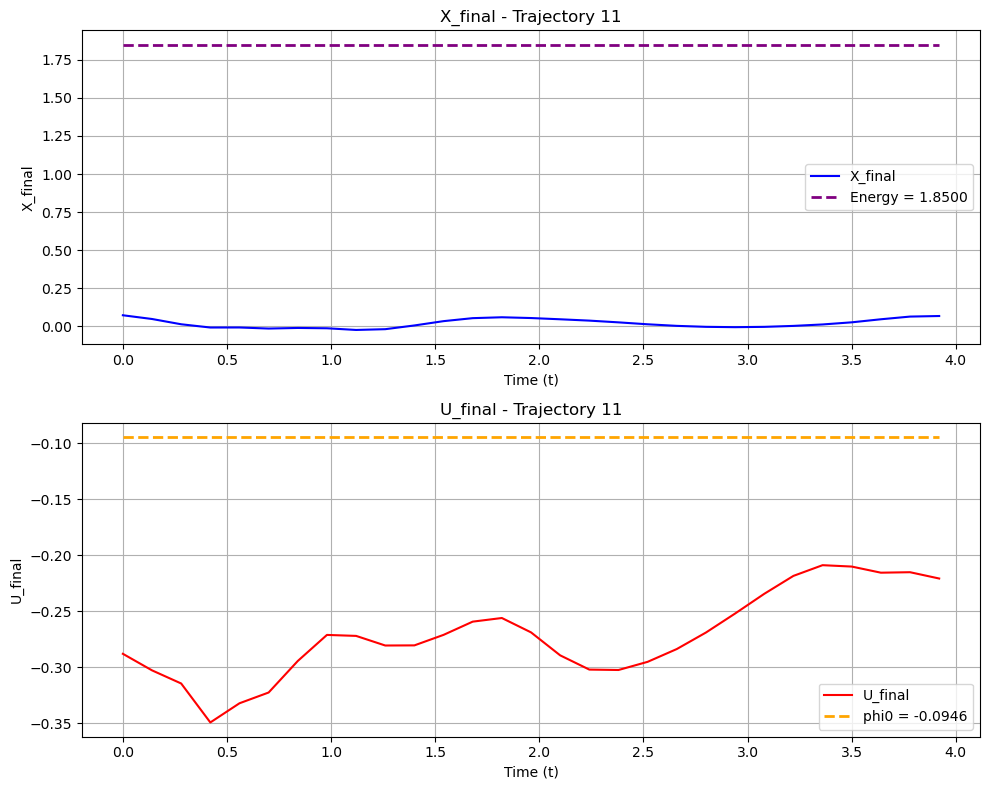

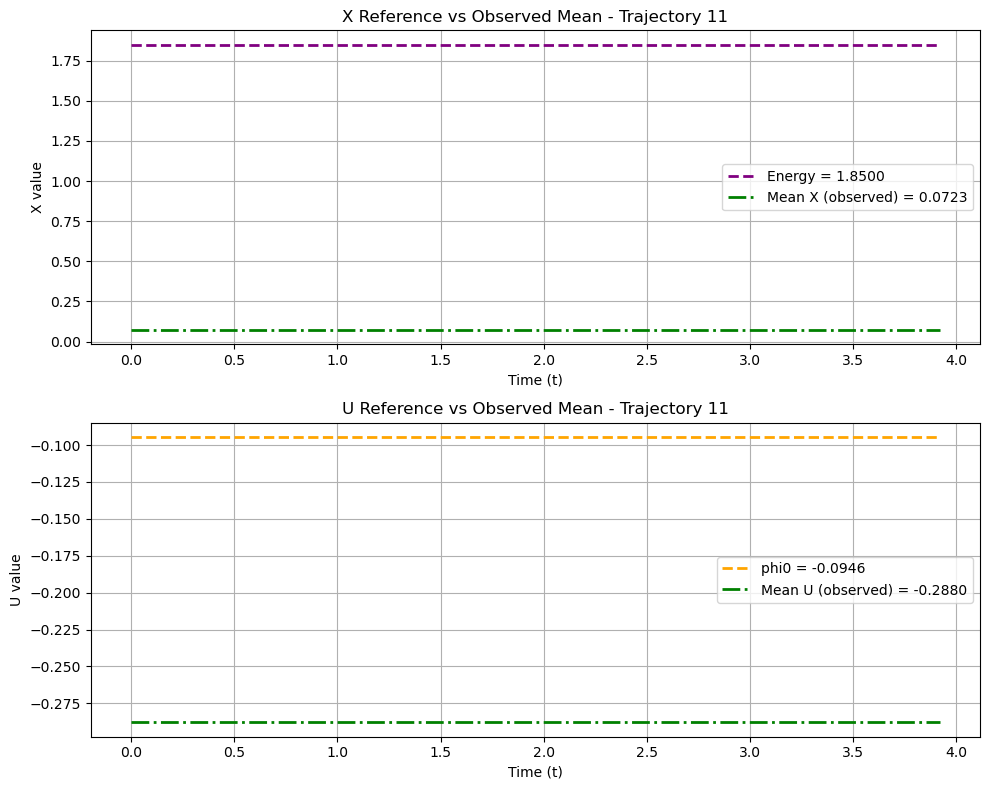

In [51]:
# Example with option_1=True (phi in X_final, energy in U_final)
plot_transformed_trajectory(
    test_id_df_low_samples_multiple_periods_pendulum, 
    test_df_low_samples_multiple_periods_pendulum, 
    trajectory_id=trajectory_id_test_multiple_periods,  # Replace with your trajectory ID
    get_data_from_trajectory_id_function=get_data_from_trajectory_id, mapping_net=mapping_net, device=device,
    max_t_training=max_t_training,
    option_1=False, 
    point_indexes_observed=point_indexes_observed
)



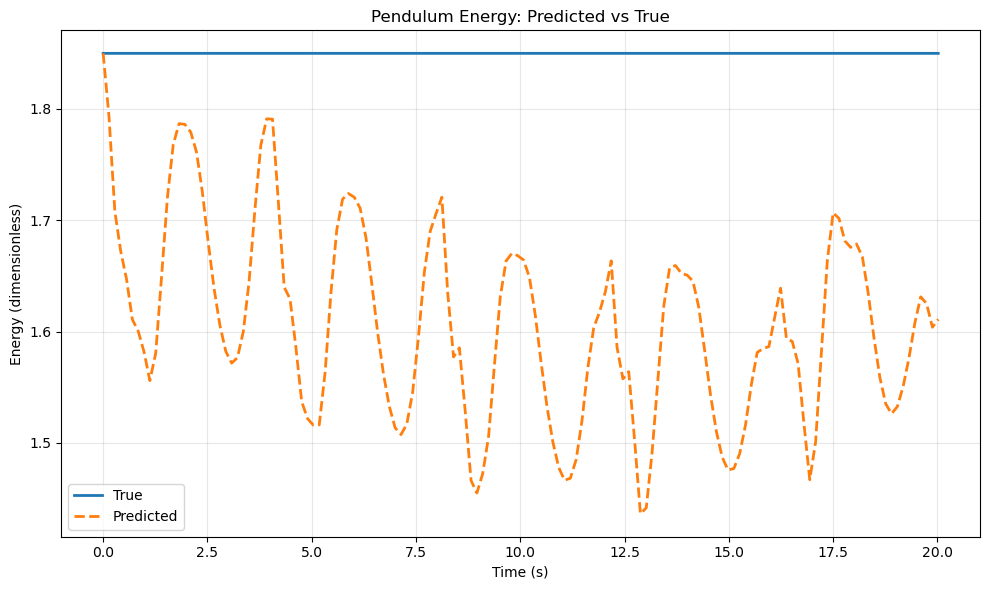

In [52]:
test_model_energy_in_single_trajectory(
    get_data_from_trajectory_id, 
    test_id_df_low_samples_multiple_periods_pendulum, 
    test_df_low_samples_multiple_periods_pendulum, 
    trajectory_id_test_multiple_periods, 
    mapping_net, 
    inverse_net, 
    device, 
    point_indexes_observed, 
    max_t_training,
    efficiently=True,
    method = "mahalanobis",
    threshold=1.0,
    dt=0.1,
    alpha=1.0,
    gamma=1.0,
    cluster_weight_threshold=0.4,
    max_n_components=5,
    search_range_lower_pct=0.5,
    search_range_upper_pct=0.6,
    case="ideal_pendulum",
    length=1.0, k=1, mass=1, g=3.0, constant=2.4,
    verbose=False,
    )


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 30
inverse_net calls: 1639
Total forward passes: 1669
Coverage: 100.0%
Observed time points: [0.]


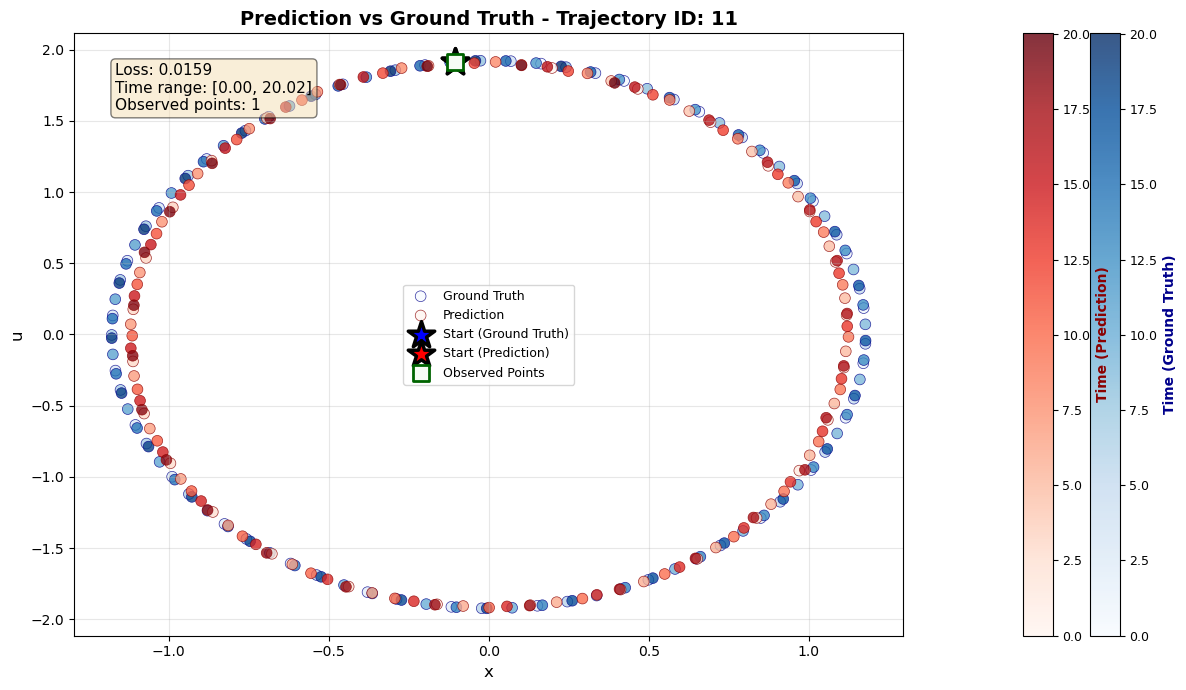

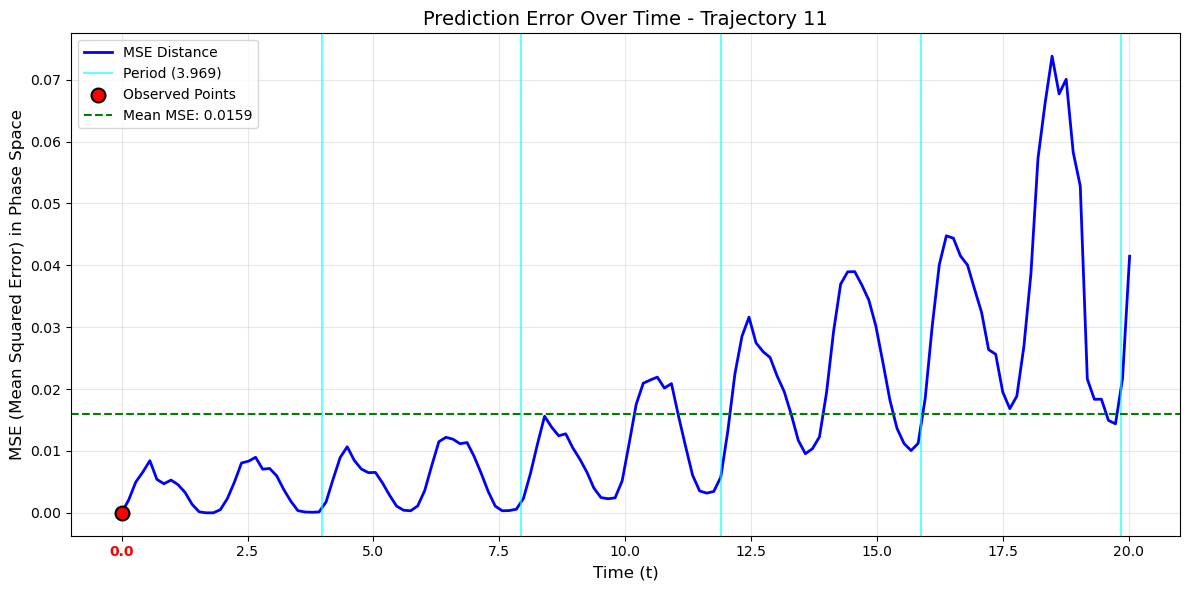

In [13]:
test_model_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
loss_type="mse", 
test_id_df=test_id_df_low_samples_multiple_periods_pendulum, 
test_df=test_df_low_samples_multiple_periods_pendulum, 
trajectory_id=trajectory_id_test_multiple_periods_ensemble, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
connect_points=False, 
portion_to_visualize=None, 
show_zeroings=False, 
show_period=True, 
period=period_test_multiple_periods_ensemble, 
max_t_training=max_t_training, 
efficiently=False, 
method="gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=9, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.21004741205686503, 
verbose=True)


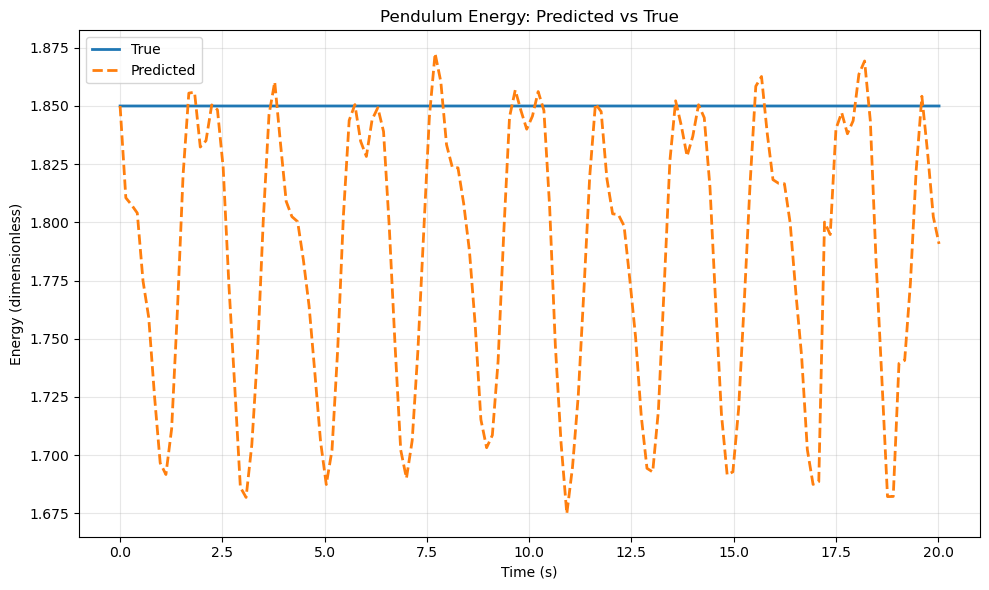

In [14]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id, 
test_id_df_low_samples_multiple_periods_pendulum, 
test_df_low_samples_multiple_periods_pendulum, 
trajectory_id_test_multiple_periods, 
mapping_net, 
inverse_net, 
device, 
point_indexes_observed, 
max_t_training,
efficiently=False, 
method="gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=9, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.21004741205686503, 
case="ideal_pendulum",
length=1.0, k=1, mass=1, g=3.0, constant=2.4,
verbose=False,
)

In [53]:
print(f"The max energy of a trajectory in the training set is: {train_id_df_low_samples_pendulum['energy'].max():.3f}\nThe high energy testing set has energies in the range: {test_id_df_high_energy_low_samples_pendulum['energy'].min():.3f}-{test_id_df_high_energy_low_samples_pendulum['energy'].max():.3f}")

The max energy of a trajectory in the training set is: 2.287
The high energy testing set has energies in the range: 2.400-4.431


   num_observed_points  mean_variance
0                    1       0.000000
1                    2       0.002165
2                    3       0.351215
3                    4       0.381879
4                    5       0.339030
5                    6       0.276871
6                    7       0.508274
7                    8       0.440335
8                    9       0.420743
9                   10       0.452335


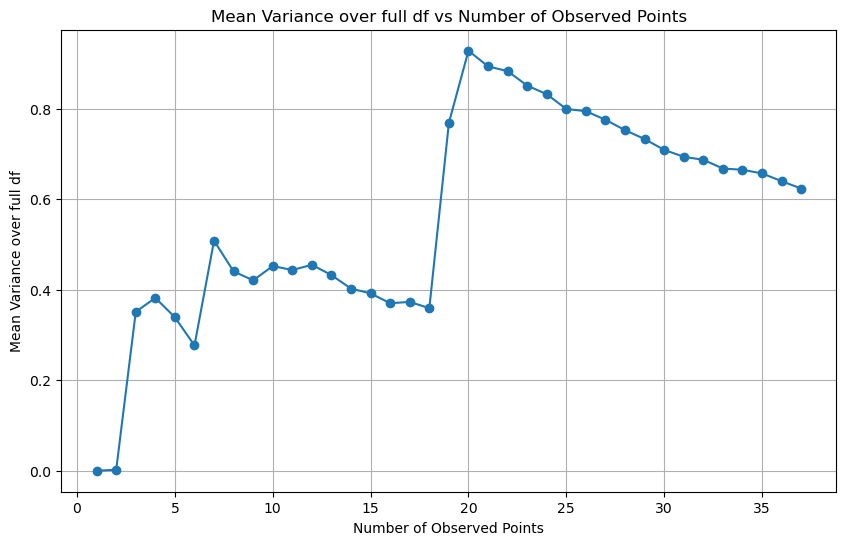

In [14]:
val_variance_per_points_df = test_model_variance_with_varying_observed_points(
get_data_from_trajectory_id_function=get_data_from_trajectory_id,
test_id_df=test_id_df_high_energy_low_samples_pendulum, 
test_df=test_df_high_energy_low_samples_pendulum, 
mapping_net=mapping_net, 
device=device)

/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:11277: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


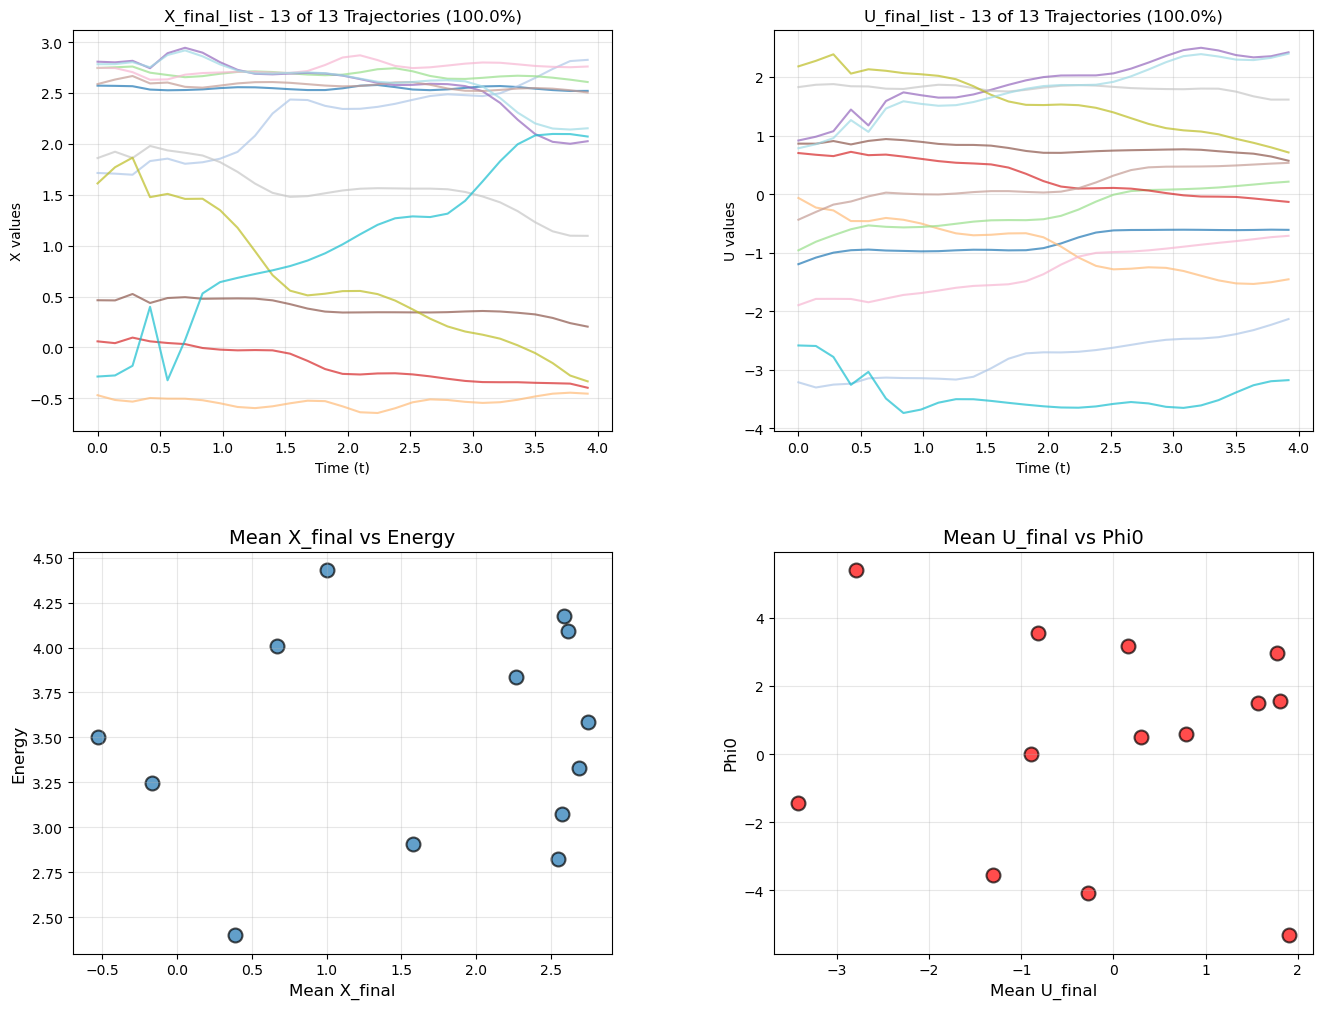

In [15]:
plot_all_transformed_trajectories(
    test_id_df_high_energy_low_samples_pendulum, 
    test_df_high_energy_low_samples_pendulum, 
    get_data_from_trajectory_id_function=get_data_from_trajectory_id,mapping_net=mapping_net, device=device,
    max_t_training=max_t_training,
    option_1=False,
    only_plot_percentage=1.0
)

In [13]:
point_indexes_observed_high_energy = [0]


    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
0               0  2.400000         0.158489              0.102304
5               5  2.823077         0.431604              0.256876
6               6  2.907692         0.485719              0.284846
8               8  3.076923         0.636246              0.362716
10             10  3.246154         0.522786              0.290161
11             11  3.330769         0.766561              0.420024
13             13  3.500000         0.870243              0.465164
14             14  3.584615         0.784308              0.414252
17             17  3.838462         1.034335              0.527938
19             19  4.007692         1.154809              0.576850
20             20  4.092308         1.293424              0.639377
21             21  4.176923         1.375907              0.673226
24             24  4.430769         1.919158              0.911740
Mean prediction loss over full dataframe: 0.8795


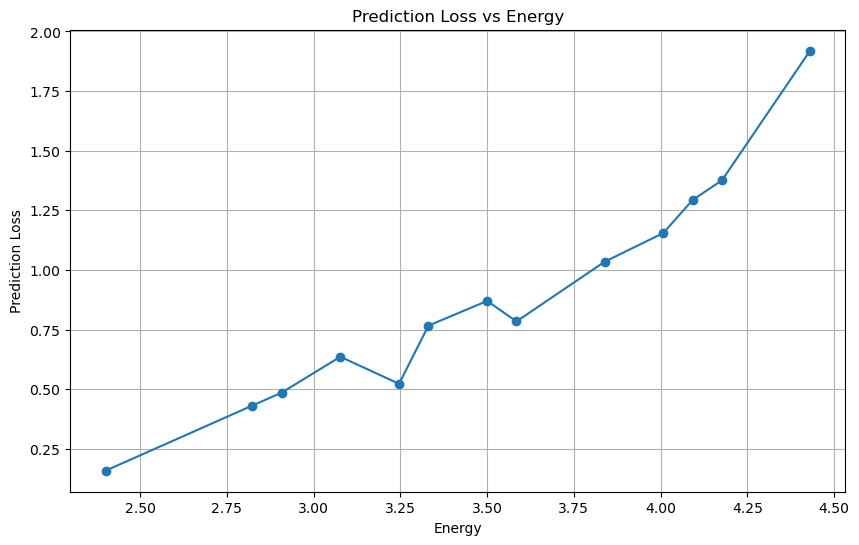

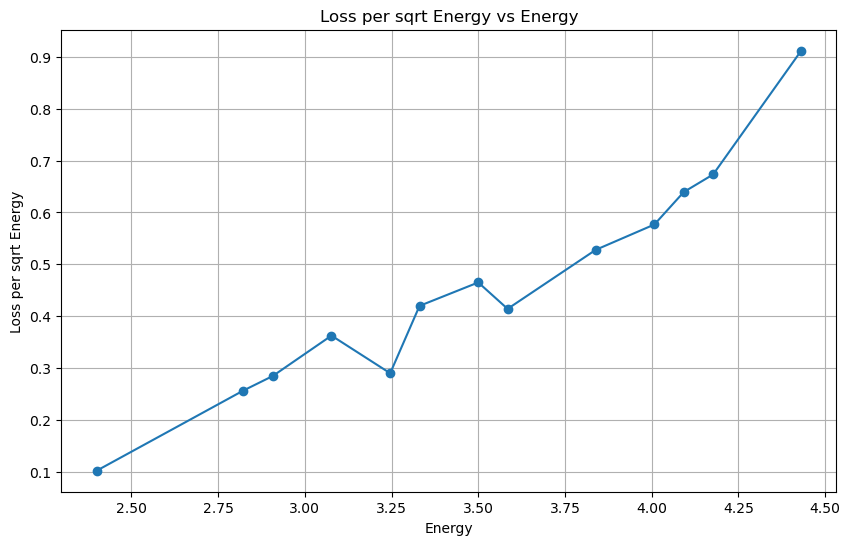

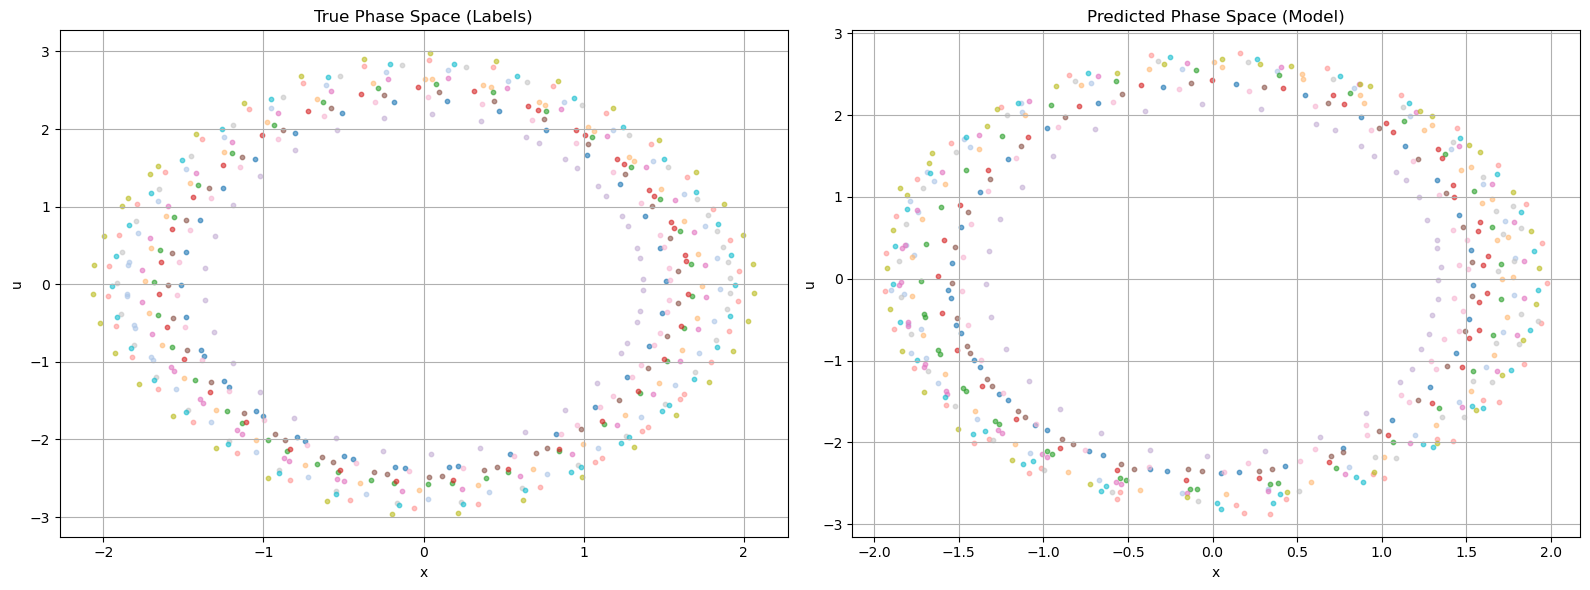

In [17]:
prediction_test_high_energy_df, mean_prediction_loss_test_high_energy, pred_test_high_energy_df = test_model_in_all_trajectories_in_df(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
prediction_loss_function=prediction_loss_euclidean, 
test_id_df=test_id_df_high_energy_low_samples_pendulum, 
test_df=test_df_high_energy_low_samples_pendulum, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed_high_energy, 
recreate_and_plot_phase_space=True, 
plot_specific_portion=1.0, 
connect_points=False, 
plot_trajectories_subsample=1.0, 
max_t_training=max_t_training, 
efficiently=True, threshold=1.0, 
search_range_lower_pct=0.5, 
search_range_upper_pct=0.6, 
verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
0               0  2.400000         0.177510              0.114582
5               5  2.823077         0.445650              0.265236
6               6  2.907692         0.444414              0.260623
8               8  3.076923         0.706750              0.402909
10             10  3.246154         0.541671              0.300643
11             11  3.330769         0.811754              0.444787
13             13  3.500000         0.860699              0.460063
14             14  3.584615         0.793893              0.419315
17             17  3.838462         1.091465              0.557098
19             19  4.007692         1.213622              0.606228
20             20  4.092308         1.405171              0.694616
21             21  4.176923         1.463856              0.716259
24             24  4.430769         1.589429              0.755095
Mean prediction loss over full dataframe: 0.8881


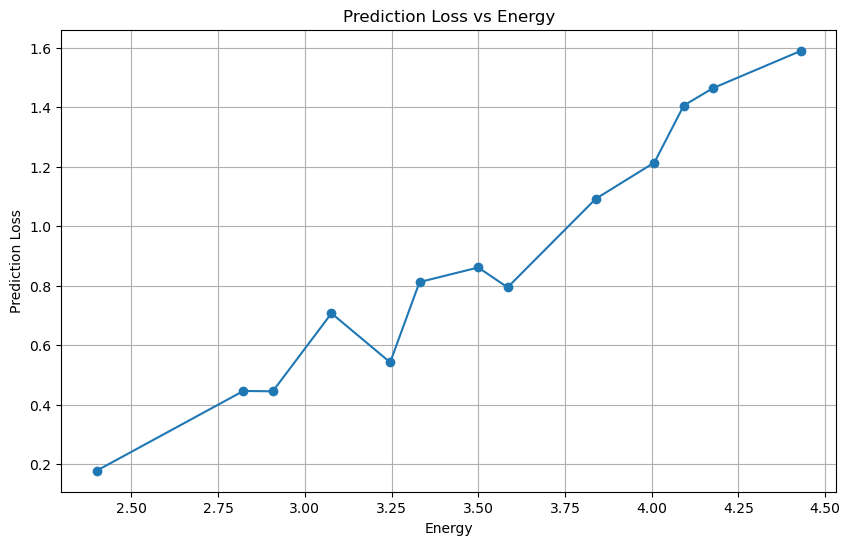

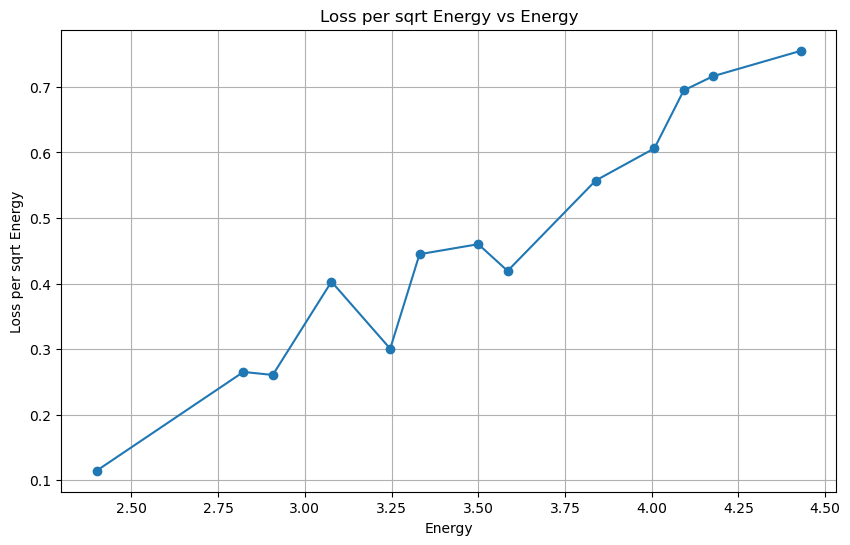

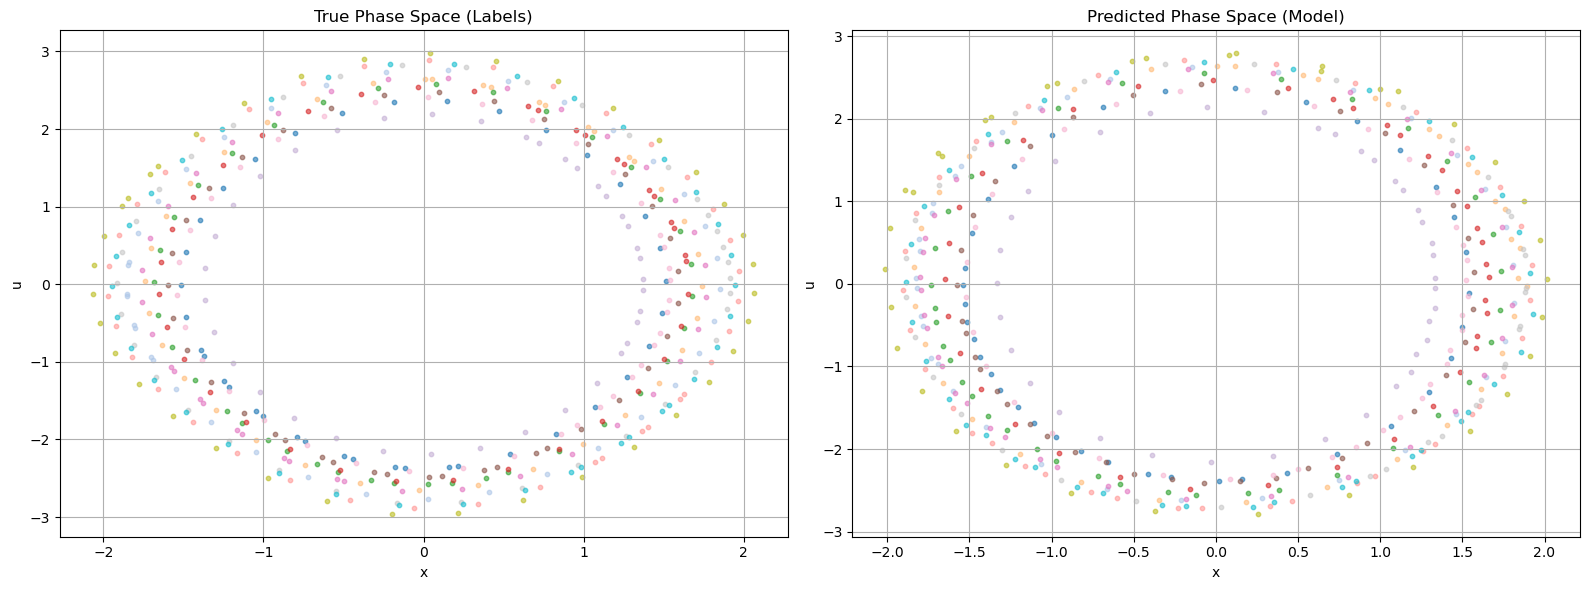

In [16]:
prediction_test_ensemble_high_energy_df, mean_prediction_loss_test_ensemble_high_energy, pred_test_ensemble_high_energy_df = test_model_in_all_trajectories_in_df(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
prediction_loss_function=prediction_loss_euclidean, 
test_id_df=test_id_df_high_energy_low_samples_pendulum, 
test_df=test_df_high_energy_low_samples_pendulum, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed_high_energy, 
recreate_and_plot_phase_space=True, 
plot_specific_portion=1.0, 
connect_points=False, 
plot_trajectories_subsample=1.0, 
max_t_training=max_t_training, 
efficiently=False, 
method="gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=9, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.21004741205686503, 
verbose=True)

In [16]:
trajectory_id_to_show_test_high_energy=24
period_test_high_energy = test_id_df_high_energy_low_samples_pendulum[test_id_df_high_energy_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_high_energy]['period'].values[0] if test_id_df_high_energy_low_samples_pendulum[test_id_df_high_energy_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_high_energy]['motion_type'].values[0] == "oscillating" else 0.0

trajectory_id_to_show_test_high_energy_ensemble=24
period_test_high_energy_ensemble = test_id_df_high_energy_low_samples_pendulum[test_id_df_high_energy_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_high_energy_ensemble]['period'].values[0] if test_id_df_high_energy_low_samples_pendulum[test_id_df_high_energy_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_high_energy_ensemble]['motion_type'].values[0] == "oscillating" else 0.0


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 2
inverse_net calls: 2
Total forward passes: 4
Observed time points: [0.]


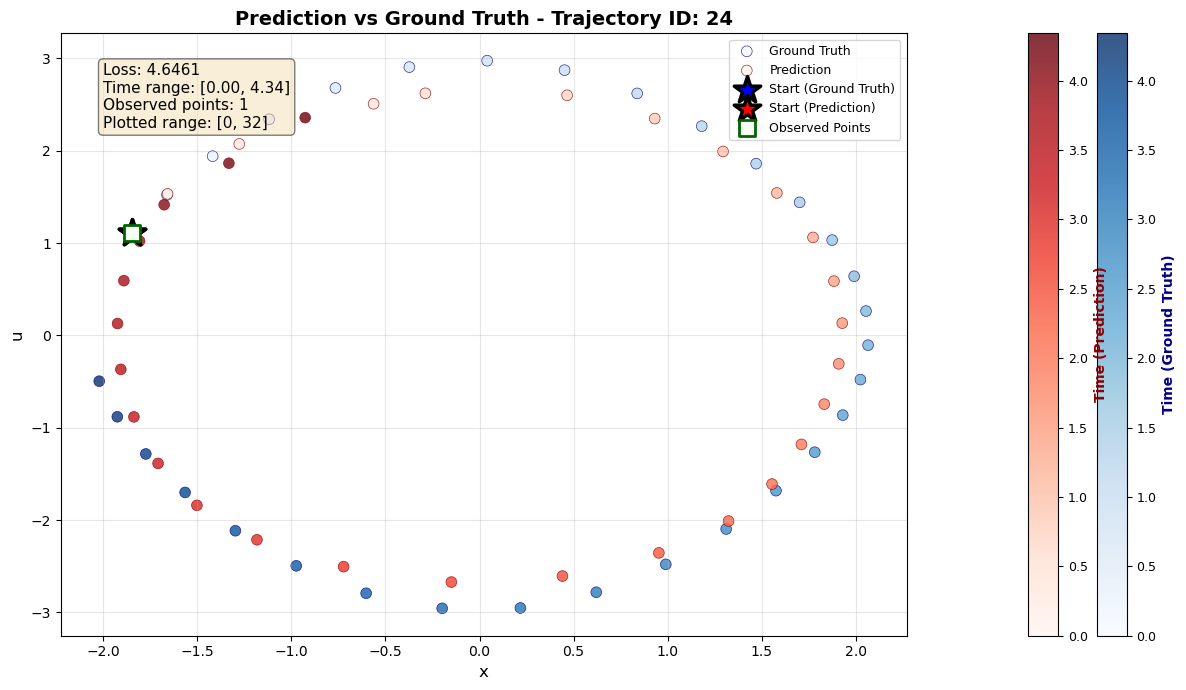

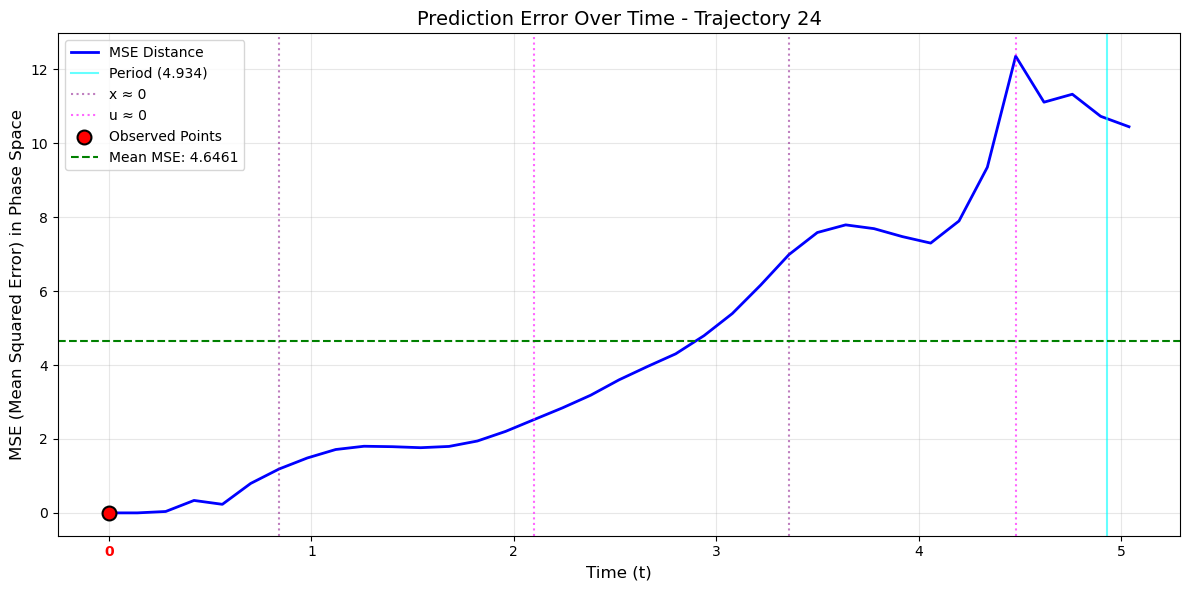

In [19]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_high_energy_low_samples_pendulum, test_df=test_df_high_energy_low_samples_pendulum, trajectory_id=trajectory_id_to_show_test_high_energy, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period_test_high_energy, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

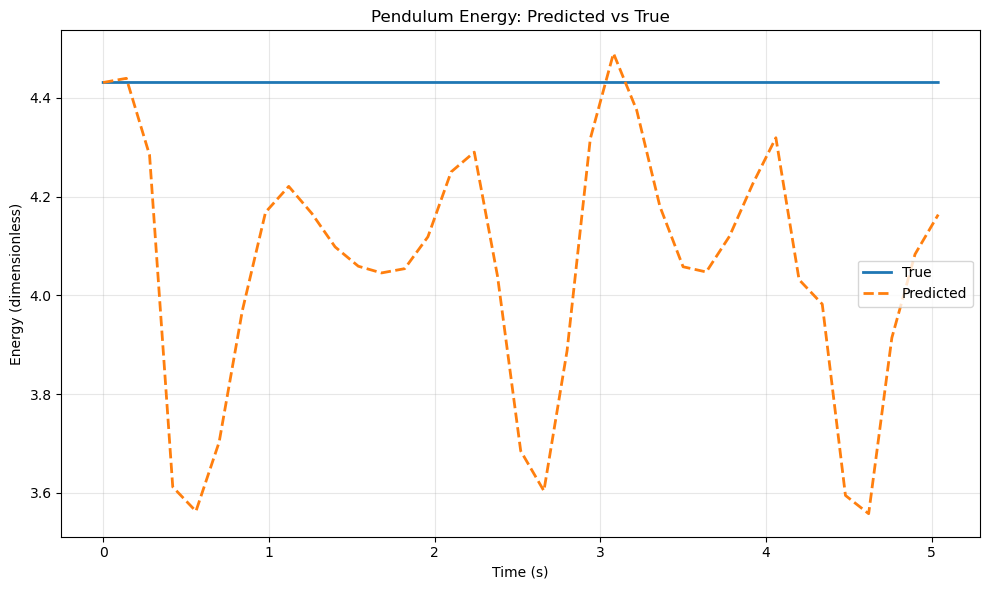

In [17]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id, 
test_id_df_high_energy_low_samples_pendulum, 
test_df_high_energy_low_samples_pendulum, 
trajectory_id_to_show_test_high_energy, 
mapping_net, 
inverse_net, 
device, 
point_indexes_observed, 
max_t_training,
efficiently=True, 
method="gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=9, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.21004741205686503, 
case="ideal_pendulum",
length=1.0, k=1, mass=1, g=3.0, constant=2.4,
verbose=False,
)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 137
Total forward passes: 141
Coverage: 100.0%
Observed time points: [0.]


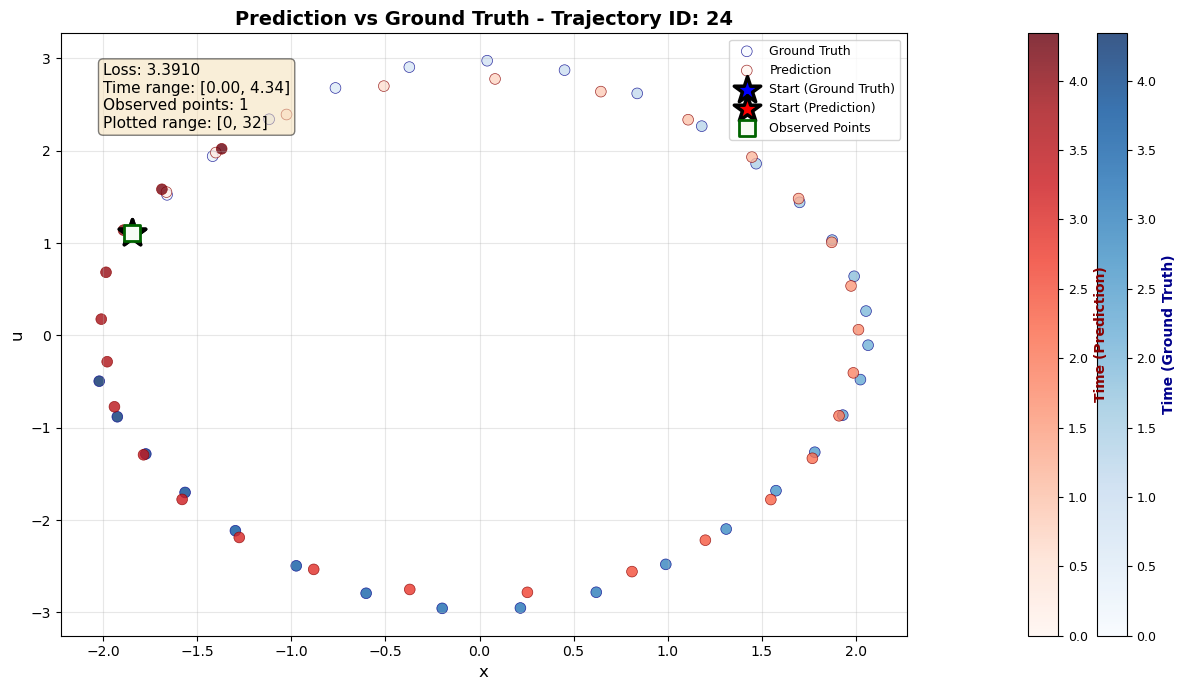

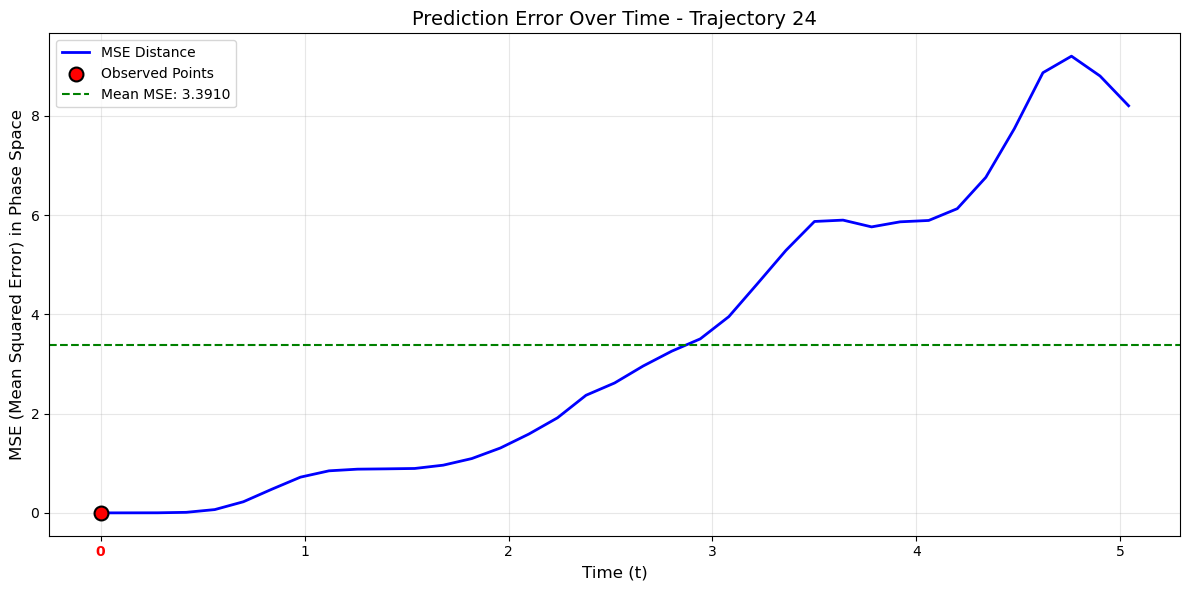

In [18]:
test_model_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
loss_type="mse", 
test_id_df=test_id_df_high_energy_low_samples_pendulum, 
test_df=test_df_high_energy_low_samples_pendulum, 
trajectory_id=trajectory_id_to_show_test_high_energy_ensemble, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed_high_energy, 
connect_points=False, 
portion_to_visualize=[0,32], 
show_zeroings=False, 
show_period=False, 
period=period_test_high_energy_ensemble, 
max_t_training=max_t_training, 
efficiently=False, 
method="gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=9, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.21004741205686503, 
verbose=True)

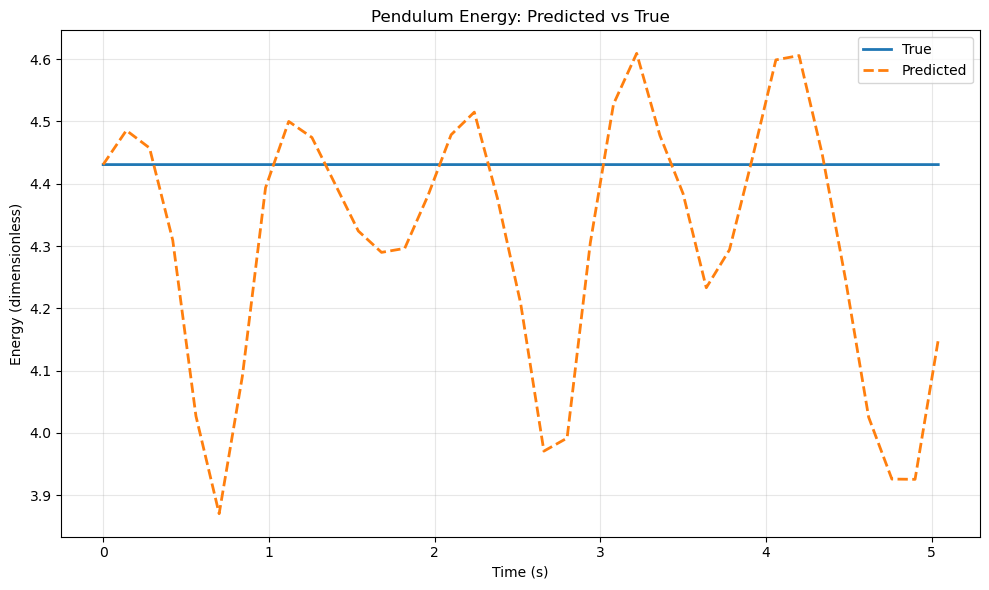

In [18]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id, 
test_id_df_high_energy_low_samples_pendulum, 
test_df_high_energy_low_samples_pendulum, 
trajectory_id_to_show_test_high_energy_ensemble, 
mapping_net, 
inverse_net, 
device, 
point_indexes_observed, 
max_t_training,
efficiently=False, 
method="gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=9, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.21004741205686503, 
case="ideal_pendulum",
length=1.0, k=1, mass=1, g=3.0, constant=2.4,
verbose=False,
)

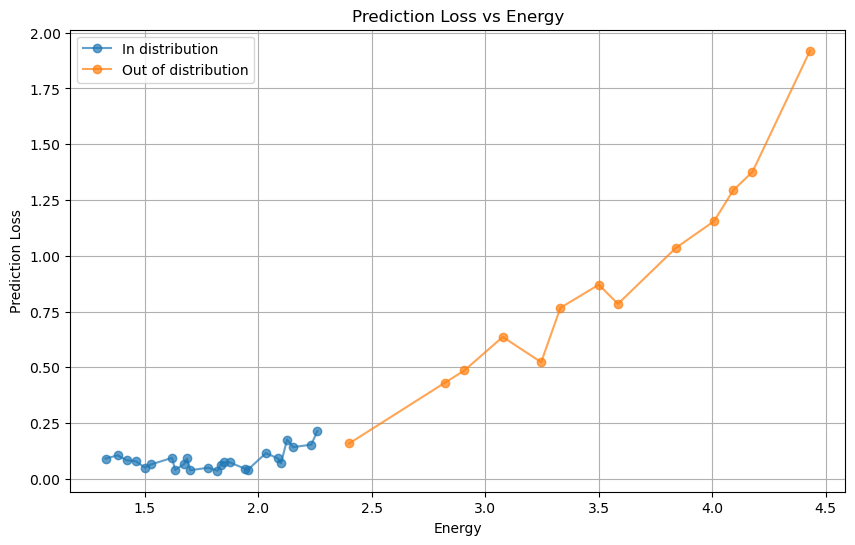

In [62]:
plot_prediction_losses([prediction_test_df, prediction_test_high_energy_df])

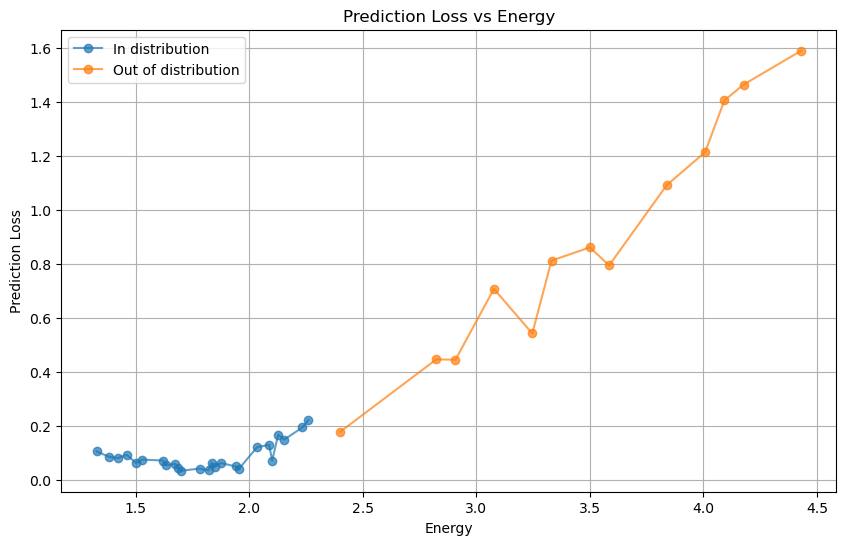

In [21]:
plot_prediction_losses([prediction_test_ensemble_df, prediction_test_ensemble_high_energy_df])